# Modelo Predicción de Ocupación

## Contenido
* Parámetros generales e Importacion de biblioticas
* Carga de los datos
* Parámetros Generales
* Preprocesamiento
 * Unificación 
* Modelo
 * Procesamiento
 * Tidy Table
 * Separación Xvar y Yvar  (número variable de periodo)
 * Separacion Train y Test
 * Configuración de los Modelos
 * Funciones 
  * F. para evaluar varios modelos
  * F. para categorizar en semáforo
  * F. Evaluación de resultados Exactitud
* Generacion de Pronosticos a futuro
 * Procesamiento entrada para pronóstico
 * Ejecución del modelos y archivo de entrega

## Parámetros generales e Importacion de biblioticas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from datetime import datetime
from dateutil.relativedelta import relativedelta
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix # es una manera para resumir los datos 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve #roc_curve
from sklearn.metrics import roc_auc_score #auc

## Carga de los datos

In [3]:
df_Nodosokla= pd.read_csv('DatosOrigen/NODOS_INFO_OOKLA.csv',sep=';', header = 0)
data_ocupacionNodo = pd.read_csv('DatosOrigen/OCUPACION_NODO.csv', sep=';')
data_NodoINFI = pd.read_csv('DatosOrigen/NODO_INFI.csv', sep=';')
data_SEG = pd.read_csv('DatosOrigen/compiladoFinal.csv', sep=';') 

### Base OOKLA

In [4]:
df_Nodosokla['DIA']=1 # le agrego la columna dia
df_Nodosokla['MES'] = [f'0{x}' if x <10 else str(x) for x in df_Nodosokla['MES']]
df_Nodosokla['DIA'] = [f'0{x}' if x <10 else str(x) for x in df_Nodosokla['DIA']]
df_Nodosokla['FECHA'] = df_Nodosokla['ANIO'].astype('str') + '-' + df_Nodosokla['MES'] + '-' + df_Nodosokla['DIA']
# eliminamos columnas cobrantes
df_Nodosokla=df_Nodosokla.drop(['DIA','MES','ANIO'], axis=1)
# ordenamos
df_Nodosokla = df_Nodosokla[['NODO','FECHA', 'OPERADOR','CANTIDAD','DOWNLOAD_KBPS','UPLOAD_KBPS','LATENCY','FLAG_LAT']] 
# # renombramos columnas
df_Nodosokla.rename(columns={'NODO':'COD_NODO'}, inplace=True)
df_Nodosokla_Claro=df_Nodosokla[df_Nodosokla["OPERADOR"]=="CLARO"]
del(df_Nodosokla_Claro['OPERADOR'])

### Base data_NodoINF

In [5]:
data_NodoINFI['DIA']=1 # le agrego la columna dia
data_NodoINFI['MES'] = [f'0{x}' if x <10 else str(x) for x in data_NodoINFI['MES']]
data_NodoINFI['DIA'] = [f'0{x}' if x <10 else str(x) for x in data_NodoINFI['DIA']]
data_NodoINFI['FECHA'] = (2000+data_NodoINFI['ANIO']).astype('str') + '-' + data_NodoINFI['MES'] + '-' + data_NodoINFI['DIA']
# eliminamos columnas sobrantes
data_NodoINFI=data_NodoINFI.drop(['DIA','MES','ANIO'], axis=1)
# # renombramos columnas
data_NodoINFI.rename(columns={'NODO':'COD_NODO'}, inplace=True)
### completar Nullos con 0
data_NodoINFI=data_NodoINFI.fillna(0)

### Base data_NodoINF data_SEG

In [6]:
data_SEG.drop(['NUEVA ESTRUCTURA'], axis=1,inplace=True)
data_SEG['SEGMENTADO']=1

## Preprocesamiento
### Unificacion

In [7]:
data_ocupacion=pd.merge(data_ocupacionNodo, data_NodoINFI, on = ('COD_NODO','FECHA'), how='left')
#data_ocupacion=pd.merge(data_ocupacion, df_Nodosokla_Claro, on = ('COD_NODO','FECHA'), how='left')
data_ocupacion=pd.merge(data_ocupacion, data_SEG, on = ('COD_NODO','FECHA'), how='left')

In [8]:
# crear factor beta y delta

### Parámetros generales

In [9]:
start = datetime.now()

In [10]:
fechaMaxima=datetime.strptime(data_ocupacion['FECHA'].max(),'%Y-%m-%d')
periodos_y=7
periodos_x=7
variable_prediccion='OCUPACION_DW'

In [11]:
fechaLimite=fechaMaxima + relativedelta(months=-1*periodos_y)
fechaInicial=fechaLimite + relativedelta(months=-1*periodos_x)

### Selección Fechas

In [12]:
## Eliminar informaición anterior Junion 2022
data_ocupacion['FECHA']=data_ocupacion['FECHA'].astype('datetime64[ns]')
### Elininar datos últimos mes
data_ocupacion=data_ocupacion[data_ocupacion['FECHA']>=fechaInicial]
### Eliminar Fecha Final  (mes incompleto)
data_ocupacion=data_ocupacion[data_ocupacion['FECHA']<fechaMaxima]

##  Funciones

In [13]:
#Funcion para Calcular el número de periodos hacia atrás
def diff_month(d1, d2):
    return (d1.year - d2.dt.year) * 12 + d1.month - d2.dt.month

In [14]:
def semaforo(df, col):
    df = df.copy()
    df.loc[(df[col]>=0.58) & (df[col]<=0.75), 'ESTATUS'] = 'AMARILLO'
    df.loc[df[col]>0.75, 'ESTATUS'] = 'ROJO'
    df.loc[df[col]<0.60, 'ESTATUS'] = 'VERDE'
    return(df)

In [15]:
def semaforoVal(val):
    #df = df.copy()
    respuesta='V'
    if (val>=0.58) & (val<=0.75):
        respuesta='A'
    elif val>0.75:
        respuesta='R'
    return(respuesta)

In [16]:
def semaforoNum2Val(val):   
    respuesta='V'
    if val==1:
        respuesta='A'
    elif val==2:
        respuesta='R'
    return(respuesta)

In [17]:
def semaforoVal2Num(val):   
    respuesta=0
    if val=='A':
        respuesta=1
    elif val=='R':
        respuesta=2
    return(respuesta)

In [18]:
def semaforoRojo(val):    
    if val>0.75:
        respuesta=1
    else :
        respuesta=0
    return(respuesta)

In [19]:
def semaforoAmarillo(val):    
    if (val>=0.58) & (val<=0.75):
        respuesta=1
    else :
        respuesta=0
    return(respuesta)

In [20]:
def semaforoRojoAmarillo(val):    
    if val>=0.58:
        respuesta=1
    else :
        respuesta=0
    return(respuesta)

In [21]:
def semaforoNum(val):
    #df = df.copy()
    respuesta=0
    if (val>=0.58) & (val<=0.75):
        respuesta=1
    elif val>0.75:
        respuesta=2
    return(respuesta)

In [22]:
def semaforoNum2Rojo(val):    
    respuesta=0
    if val==2:
        respuesta=1    
    return(respuesta)

In [23]:
def semaforoNum2Amarillo(val):    
    respuesta=0
    if val==1:
        respuesta=1    
    return(respuesta)

In [24]:
def semaforoNum2RojoAmarillo(val):    
    respuesta=0
    if val>=1:
        respuesta=1    
    return(respuesta)

In [25]:
def medidasEvaluacion(matrizConfucion):
    exactitud=np.trace(matrizConfucion)/matrizConfucion.sum()
    print ('exactitud:', exactitud)
    sensibilidad=[0]*3
    especificidad=[0]*3
    for i in range(0,len(matrizConfucion)):
        sensibilidad[i]=matrizConfucion[i,i]/matrizConfucion.sum(axis=1)[i]
        especificidad[i]=np.delete(np.delete(matrizConfucion,i, axis=0),i,axis=1).sum()/np.delete(matrizConfucion,i, axis=0).sum()
        print ('sensibilidad ',i,": ",sensibilidad[i])
        print ('especificidad ',i,": ",especificidad[i])

In [26]:
def sampling_strategy(X,y,n_samples,t='majority'):
    target_classes=''
    if t== 'majority':
        target_classes= y.value_counts() >n_samples
    elif t== 'minority':
        target_classes = y.value_counts() < n_samples
    tc=target_classes[target_classes ==True].index
    #target_classes_all=y.value_counts().index
    sampling_strategy={}
    for target in tc:
        sampling_strategy[target]= n_samples
    return sampling_strategy

In [27]:
def df2Feature_importanceClass(x_train_b,mod,title):
    #shap_test = x_train_b.sample(1000)
    shap_test = x_train_b
    shap_values = shap.TreeExplainer(mod).shap_values(shap_test)
    plt.figure()
    plt.title(title)
    shap.summary_plot(shap_values, shap_test,max_display=30)
    plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
    plt.show();

## Modelo
### Procesamiento

In [28]:
data_ocupacion['mesAnt']=(periodos_x+periodos_y)-diff_month(fechaMaxima,data_ocupacion['FECHA'])
### Ordenar por fecha
data_ocupacion=data_ocupacion.sort_values(["FECHA","COD_NODO"], ascending = (True, True))

### Seleccion Nodos para el Modelo

In [29]:
### Solo Nodos con información completa
seleccion=data_ocupacion[['COD_NODO',variable_prediccion]].groupby('COD_NODO').count()
seleccion[seleccion[variable_prediccion]>=periodos_y+periodos_x+1]
seleccion.rename(columns={variable_prediccion:'noRegVarPre'}, inplace=True)
data_ocupacion=data_ocupacion.merge(seleccion, on='COD_NODO', how='left')
data_ocupacion=data_ocupacion[data_ocupacion['noRegVarPre']>=periodos_y+periodos_x]
data_ocupacion.drop(columns='noRegVarPre', inplace=True)
### Nodos No Segmentados en el periodo de tiempo considerado
data_ocupacion=data_ocupacion[data_ocupacion['SEGMENTADO']!=1]
data_ocupacion.drop(columns='SEGMENTADO', inplace=True)
### Eliminar datos con nullos
data_ocupacion=data_ocupacion.dropna()

###  Selección Columnas

In [30]:
selCols=['COD_NODO','FECHA','OCUPACION_DW','OCUPACION_UP','SERV_INT','mesAnt']
data_ocupacionC=data_ocupacion.copy()
data_ocupacion=data_ocupacion[selCols]

### Tidy Tables

#### Regresión

In [31]:
cols=data_ocupacion.columns
cols=cols[2:-1]

In [32]:
cols_x=[]
for i, col in enumerate(cols):
    tablaAnalisis = pd.pivot_table(data_ocupacion.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisis.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisis.columns}, inplace=True)
    #Identificacion Columnas X y Y    
    cols_x=cols_x+[(col+"-"+str(x)) for x in range(0,periodos_x)]    
    if i==0:
        tablaAnalisisTotal = tablaAnalisis
    else:
        tablaAnalisisTotal = tablaAnalisisTotal.merge(tablaAnalisis, how='outer', on='COD_NODO')

In [33]:
cols_x=sorted(list(set(cols_x)& set(tablaAnalisisTotal.columns.tolist())))

In [34]:
cols_y=[(variable_prediccion+"-"+str(x)) for x in range(periodos_x,periodos_x+periodos_y-1)]

In [35]:
tablaAnalisisTotal=tablaAnalisisTotal.dropna()

In [36]:
data_ocupacionC.head()

,COD_NODO,FECHA,OCUPACION_DW,OCUPACION_UP,CANT_USER,PROM_VEL,MEDIANA_VEL,VEL_ME_8,VEL_10_25,VEL_30,...,VEL_MAX,VEL_MIN,RENTA,PROM_RENTA,CONVERGENTE,SERV_INT,SERV_TV,SERV_VOZ,CANT_CALL,mesAnt
0,01J,2020-06-01,0.263806,0.181200,24.0,41.0,30.0,3.0,3.0,9.0,...,100.0,5.0,2598062.0,108253.0,3.0,24.0,19.0,16.0,0.0,0
1,01S,2020-06-01,0.195382,0.180599,77.0,37.0,30.0,16.0,7.0,23.0,...,150.0,5.0,7494860.0,97336.0,45.0,77.0,58.0,64.0,10.0,0
3,02J,2020-06-01,0.263806,0.181200,14.0,43.0,30.0,0.0,5.0,3.0,...,150.0,10.0,1880516.0,134323.0,6.0,14.0,11.0,13.0,0.0,0
4,02S,2020-06-01,0.195382,0.145466,61.0,28.0,30.0,12.0,13.0,18.0,...,100.0,5.0,5881685.0,96421.0,22.0,61.0,51.0,54.0,5.0,0
5,03J,2020-06-01,0.263806,0.181200,26.0,30.0,30.0,2.0,8.0,7.0,...,75.0,3.0,2983096.0,114734.0,9.0,26.0,25.0,23.0,2.0,0


#### Clasificación

In [37]:
colsC=data_ocupacionC.columns
colsC=colsC[2:-1]

In [38]:
cols_xC=[]
for i, col in enumerate(colsC):
    tablaAnalisis = pd.pivot_table(data_ocupacionC.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisis.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisis.columns}, inplace=True)
    #Identificacion Columnas X y Y    
    cols_xC=cols_xC+[(col+"-"+str(x)) for x in range(0,periodos_x)]    
    if i==0:
        tablaAnalisisTotalC = tablaAnalisis
    else:
        tablaAnalisisTotalC = tablaAnalisisTotalC.merge(tablaAnalisis, how='outer', on='COD_NODO')
tablaAnalisisTotalC=tablaAnalisisTotalC.dropna()

In [39]:
cols_xC=sorted(list(set(cols_xC)& set(tablaAnalisisTotalC.columns.tolist())))

### Separación Xvar y Yvar (número variable de periodo)

In [40]:
Xvar=tablaAnalisisTotal[cols_x]
XvarC=tablaAnalisisTotalC[cols_xC]
yvar=tablaAnalisisTotal[cols_y]

In [41]:
for col in cols_y:    
    yvar[col+'_sem']=yvar[col].apply(semaforoRojo)
    yvar[col+'_sem2']=yvar[col].apply(semaforoNum)    

yColClass=[s + '_sem2' for s in cols_y]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Separacion Train y Test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(Xvar, yvar, test_size = 0.3, random_state = 86, shuffle= True)

##  Modelos ML

### XGBRegressor

In [43]:
modelos={}
for yCol in cols_y:
    print(yCol)
    y_train_aux=y_train[yCol]
    y_test_aux=y_test[yCol]
    dicModelo={}        
    dicModelo['modelo']=xgb.XGBRegressor(max_depth=80, verbosity= 0, subsample=0.5,  n_estimators=472, n_jobs=-1, objective='reg:squarederror', booster='gbtree', random_state=42, learning_rate=0.04, reg_lambda=1)
    dicModelo['modelo'].fit(X_train, y_train_aux, eval_set=[(X_train, y_train_aux), (X_test, y_test_aux)])
    dicModelo['predictions'] = dicModelo['modelo'].predict(X_test)
    dicModelo['explanation']=shap.TreeExplainer(dicModelo['modelo'])    
    modelos[yCol]=dicModelo    

OCUPACION_DW-7
[0]	validation_0-rmse:0.18240	validation_1-rmse:0.17944
[1]	validation_0-rmse:0.17543	validation_1-rmse:0.17263
[2]	validation_0-rmse:0.16874	validation_1-rmse:0.16607
[3]	validation_0-rmse:0.16231	validation_1-rmse:0.15980
[4]	validation_0-rmse:0.15614	validation_1-rmse:0.15376
[5]	validation_0-rmse:0.15024	validation_1-rmse:0.14800
[6]	validation_0-rmse:0.14461	validation_1-rmse:0.14250
[7]	validation_0-rmse:0.13919	validation_1-rmse:0.13724
[8]	validation_0-rmse:0.13399	validation_1-rmse:0.13220
[9]	validation_0-rmse:0.12898	validation_1-rmse:0.12733
[10]	validation_0-rmse:0.12415	validation_1-rmse:0.12265
[11]	validation_0-rmse:0.11953	validation_1-rmse:0.11819
[12]	validation_0-rmse:0.11510	validation_1-rmse:0.11392
[13]	validation_0-rmse:0.11086	validation_1-rmse:0.10985
[14]	validation_0-rmse:0.10678	validation_1-rmse:0.10591
[15]	validation_0-rmse:0.10288	validation_1-rmse:0.10215
[16]	validation_0-rmse:0.09916	validation_1-rmse:0.09856
[17]	validation_0-rmse:0.0

[143]	validation_0-rmse:0.00649	validation_1-rmse:0.02771
[144]	validation_0-rmse:0.00641	validation_1-rmse:0.02770
[145]	validation_0-rmse:0.00634	validation_1-rmse:0.02769
[146]	validation_0-rmse:0.00627	validation_1-rmse:0.02769
[147]	validation_0-rmse:0.00619	validation_1-rmse:0.02768
[148]	validation_0-rmse:0.00611	validation_1-rmse:0.02767
[149]	validation_0-rmse:0.00604	validation_1-rmse:0.02765
[150]	validation_0-rmse:0.00597	validation_1-rmse:0.02764
[151]	validation_0-rmse:0.00590	validation_1-rmse:0.02764
[152]	validation_0-rmse:0.00582	validation_1-rmse:0.02764
[153]	validation_0-rmse:0.00576	validation_1-rmse:0.02763
[154]	validation_0-rmse:0.00571	validation_1-rmse:0.02762
[155]	validation_0-rmse:0.00565	validation_1-rmse:0.02761
[156]	validation_0-rmse:0.00559	validation_1-rmse:0.02761
[157]	validation_0-rmse:0.00552	validation_1-rmse:0.02759
[158]	validation_0-rmse:0.00545	validation_1-rmse:0.02759
[159]	validation_0-rmse:0.00540	validation_1-rmse:0.02757
[160]	validati

[285]	validation_0-rmse:0.00151	validation_1-rmse:0.02722
[286]	validation_0-rmse:0.00150	validation_1-rmse:0.02722
[287]	validation_0-rmse:0.00149	validation_1-rmse:0.02721
[288]	validation_0-rmse:0.00147	validation_1-rmse:0.02721
[289]	validation_0-rmse:0.00145	validation_1-rmse:0.02721
[290]	validation_0-rmse:0.00144	validation_1-rmse:0.02721
[291]	validation_0-rmse:0.00143	validation_1-rmse:0.02721
[292]	validation_0-rmse:0.00142	validation_1-rmse:0.02721
[293]	validation_0-rmse:0.00141	validation_1-rmse:0.02721
[294]	validation_0-rmse:0.00139	validation_1-rmse:0.02721
[295]	validation_0-rmse:0.00138	validation_1-rmse:0.02721
[296]	validation_0-rmse:0.00137	validation_1-rmse:0.02721
[297]	validation_0-rmse:0.00136	validation_1-rmse:0.02721
[298]	validation_0-rmse:0.00135	validation_1-rmse:0.02720
[299]	validation_0-rmse:0.00133	validation_1-rmse:0.02721
[300]	validation_0-rmse:0.00132	validation_1-rmse:0.02720
[301]	validation_0-rmse:0.00131	validation_1-rmse:0.02720
[302]	validati

[427]	validation_0-rmse:0.00063	validation_1-rmse:0.02718
[428]	validation_0-rmse:0.00062	validation_1-rmse:0.02718
[429]	validation_0-rmse:0.00062	validation_1-rmse:0.02718
[430]	validation_0-rmse:0.00062	validation_1-rmse:0.02717
[431]	validation_0-rmse:0.00062	validation_1-rmse:0.02717
[432]	validation_0-rmse:0.00062	validation_1-rmse:0.02717
[433]	validation_0-rmse:0.00062	validation_1-rmse:0.02717
[434]	validation_0-rmse:0.00062	validation_1-rmse:0.02717
[435]	validation_0-rmse:0.00061	validation_1-rmse:0.02717
[436]	validation_0-rmse:0.00061	validation_1-rmse:0.02717
[437]	validation_0-rmse:0.00061	validation_1-rmse:0.02717
[438]	validation_0-rmse:0.00061	validation_1-rmse:0.02717
[439]	validation_0-rmse:0.00060	validation_1-rmse:0.02717
[440]	validation_0-rmse:0.00060	validation_1-rmse:0.02717
[441]	validation_0-rmse:0.00060	validation_1-rmse:0.02717
[442]	validation_0-rmse:0.00060	validation_1-rmse:0.02717
[443]	validation_0-rmse:0.00060	validation_1-rmse:0.02717
[444]	validati

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


OCUPACION_DW-8
[0]	validation_0-rmse:0.17505	validation_1-rmse:0.17144
[1]	validation_0-rmse:0.16844	validation_1-rmse:0.16499
[2]	validation_0-rmse:0.16210	validation_1-rmse:0.15881
[3]	validation_0-rmse:0.15601	validation_1-rmse:0.15287
[4]	validation_0-rmse:0.15019	validation_1-rmse:0.14721
[5]	validation_0-rmse:0.14461	validation_1-rmse:0.14179
[6]	validation_0-rmse:0.13925	validation_1-rmse:0.13662
[7]	validation_0-rmse:0.13412	validation_1-rmse:0.13164
[8]	validation_0-rmse:0.12918	validation_1-rmse:0.12687
[9]	validation_0-rmse:0.12443	validation_1-rmse:0.12227
[10]	validation_0-rmse:0.11985	validation_1-rmse:0.11791
[11]	validation_0-rmse:0.11550	validation_1-rmse:0.11376
[12]	validation_0-rmse:0.11133	validation_1-rmse:0.10977
[13]	validation_0-rmse:0.10734	validation_1-rmse:0.10600
[14]	validation_0-rmse:0.10346	validation_1-rmse:0.10230
[15]	validation_0-rmse:0.09977	validation_1-rmse:0.09877
[16]	validation_0-rmse:0.09625	validation_1-rmse:0.09548
[17]	validation_0-rmse:0.0

[143]	validation_0-rmse:0.00740	validation_1-rmse:0.03110
[144]	validation_0-rmse:0.00732	validation_1-rmse:0.03108
[145]	validation_0-rmse:0.00724	validation_1-rmse:0.03107
[146]	validation_0-rmse:0.00715	validation_1-rmse:0.03106
[147]	validation_0-rmse:0.00707	validation_1-rmse:0.03105
[148]	validation_0-rmse:0.00699	validation_1-rmse:0.03104
[149]	validation_0-rmse:0.00692	validation_1-rmse:0.03104
[150]	validation_0-rmse:0.00686	validation_1-rmse:0.03102
[151]	validation_0-rmse:0.00678	validation_1-rmse:0.03101
[152]	validation_0-rmse:0.00669	validation_1-rmse:0.03100
[153]	validation_0-rmse:0.00662	validation_1-rmse:0.03099
[154]	validation_0-rmse:0.00656	validation_1-rmse:0.03097
[155]	validation_0-rmse:0.00648	validation_1-rmse:0.03096
[156]	validation_0-rmse:0.00641	validation_1-rmse:0.03095
[157]	validation_0-rmse:0.00634	validation_1-rmse:0.03094
[158]	validation_0-rmse:0.00626	validation_1-rmse:0.03092
[159]	validation_0-rmse:0.00620	validation_1-rmse:0.03092
[160]	validati

[285]	validation_0-rmse:0.00174	validation_1-rmse:0.03055
[286]	validation_0-rmse:0.00173	validation_1-rmse:0.03055
[287]	validation_0-rmse:0.00171	validation_1-rmse:0.03056
[288]	validation_0-rmse:0.00169	validation_1-rmse:0.03055
[289]	validation_0-rmse:0.00168	validation_1-rmse:0.03056
[290]	validation_0-rmse:0.00167	validation_1-rmse:0.03055
[291]	validation_0-rmse:0.00165	validation_1-rmse:0.03055
[292]	validation_0-rmse:0.00164	validation_1-rmse:0.03055
[293]	validation_0-rmse:0.00162	validation_1-rmse:0.03056
[294]	validation_0-rmse:0.00161	validation_1-rmse:0.03055
[295]	validation_0-rmse:0.00159	validation_1-rmse:0.03055
[296]	validation_0-rmse:0.00158	validation_1-rmse:0.03055
[297]	validation_0-rmse:0.00156	validation_1-rmse:0.03055
[298]	validation_0-rmse:0.00155	validation_1-rmse:0.03055
[299]	validation_0-rmse:0.00153	validation_1-rmse:0.03055
[300]	validation_0-rmse:0.00152	validation_1-rmse:0.03055
[301]	validation_0-rmse:0.00151	validation_1-rmse:0.03055
[302]	validati

[427]	validation_0-rmse:0.00066	validation_1-rmse:0.03051
[428]	validation_0-rmse:0.00066	validation_1-rmse:0.03051
[429]	validation_0-rmse:0.00065	validation_1-rmse:0.03051
[430]	validation_0-rmse:0.00065	validation_1-rmse:0.03051
[431]	validation_0-rmse:0.00065	validation_1-rmse:0.03051
[432]	validation_0-rmse:0.00065	validation_1-rmse:0.03051
[433]	validation_0-rmse:0.00065	validation_1-rmse:0.03051
[434]	validation_0-rmse:0.00064	validation_1-rmse:0.03051
[435]	validation_0-rmse:0.00064	validation_1-rmse:0.03051
[436]	validation_0-rmse:0.00064	validation_1-rmse:0.03051
[437]	validation_0-rmse:0.00064	validation_1-rmse:0.03051
[438]	validation_0-rmse:0.00064	validation_1-rmse:0.03051
[439]	validation_0-rmse:0.00063	validation_1-rmse:0.03051
[440]	validation_0-rmse:0.00063	validation_1-rmse:0.03051
[441]	validation_0-rmse:0.00063	validation_1-rmse:0.03051
[442]	validation_0-rmse:0.00063	validation_1-rmse:0.03051
[443]	validation_0-rmse:0.00062	validation_1-rmse:0.03051
[444]	validati

[98]	validation_0-rmse:0.01594	validation_1-rmse:0.04999
[99]	validation_0-rmse:0.01572	validation_1-rmse:0.04996
[100]	validation_0-rmse:0.01549	validation_1-rmse:0.04994
[101]	validation_0-rmse:0.01527	validation_1-rmse:0.04990
[102]	validation_0-rmse:0.01505	validation_1-rmse:0.04986
[103]	validation_0-rmse:0.01485	validation_1-rmse:0.04982
[104]	validation_0-rmse:0.01464	validation_1-rmse:0.04977
[105]	validation_0-rmse:0.01445	validation_1-rmse:0.04977
[106]	validation_0-rmse:0.01427	validation_1-rmse:0.04976
[107]	validation_0-rmse:0.01409	validation_1-rmse:0.04973
[108]	validation_0-rmse:0.01390	validation_1-rmse:0.04973
[109]	validation_0-rmse:0.01372	validation_1-rmse:0.04971
[110]	validation_0-rmse:0.01354	validation_1-rmse:0.04970
[111]	validation_0-rmse:0.01335	validation_1-rmse:0.04968
[112]	validation_0-rmse:0.01317	validation_1-rmse:0.04965
[113]	validation_0-rmse:0.01301	validation_1-rmse:0.04962
[114]	validation_0-rmse:0.01285	validation_1-rmse:0.04958
[115]	validation

[240]	validation_0-rmse:0.00330	validation_1-rmse:0.04876
[241]	validation_0-rmse:0.00327	validation_1-rmse:0.04876
[242]	validation_0-rmse:0.00323	validation_1-rmse:0.04876
[243]	validation_0-rmse:0.00320	validation_1-rmse:0.04875
[244]	validation_0-rmse:0.00318	validation_1-rmse:0.04875
[245]	validation_0-rmse:0.00315	validation_1-rmse:0.04875
[246]	validation_0-rmse:0.00311	validation_1-rmse:0.04875
[247]	validation_0-rmse:0.00309	validation_1-rmse:0.04875
[248]	validation_0-rmse:0.00305	validation_1-rmse:0.04874
[249]	validation_0-rmse:0.00303	validation_1-rmse:0.04874
[250]	validation_0-rmse:0.00300	validation_1-rmse:0.04874
[251]	validation_0-rmse:0.00297	validation_1-rmse:0.04874
[252]	validation_0-rmse:0.00294	validation_1-rmse:0.04873
[253]	validation_0-rmse:0.00292	validation_1-rmse:0.04873
[254]	validation_0-rmse:0.00289	validation_1-rmse:0.04873
[255]	validation_0-rmse:0.00285	validation_1-rmse:0.04873
[256]	validation_0-rmse:0.00282	validation_1-rmse:0.04873
[257]	validati

[382]	validation_0-rmse:0.00096	validation_1-rmse:0.04869
[383]	validation_0-rmse:0.00096	validation_1-rmse:0.04869
[384]	validation_0-rmse:0.00095	validation_1-rmse:0.04869
[385]	validation_0-rmse:0.00094	validation_1-rmse:0.04869
[386]	validation_0-rmse:0.00093	validation_1-rmse:0.04869
[387]	validation_0-rmse:0.00093	validation_1-rmse:0.04869
[388]	validation_0-rmse:0.00092	validation_1-rmse:0.04869
[389]	validation_0-rmse:0.00092	validation_1-rmse:0.04869
[390]	validation_0-rmse:0.00091	validation_1-rmse:0.04869
[391]	validation_0-rmse:0.00090	validation_1-rmse:0.04869
[392]	validation_0-rmse:0.00090	validation_1-rmse:0.04869
[393]	validation_0-rmse:0.00089	validation_1-rmse:0.04869
[394]	validation_0-rmse:0.00089	validation_1-rmse:0.04869
[395]	validation_0-rmse:0.00088	validation_1-rmse:0.04869
[396]	validation_0-rmse:0.00087	validation_1-rmse:0.04869
[397]	validation_0-rmse:0.00087	validation_1-rmse:0.04869
[398]	validation_0-rmse:0.00086	validation_1-rmse:0.04869
[399]	validati

[53]	validation_0-rmse:0.04036	validation_1-rmse:0.06798
[54]	validation_0-rmse:0.03952	validation_1-rmse:0.06765
[55]	validation_0-rmse:0.03869	validation_1-rmse:0.06729
[56]	validation_0-rmse:0.03790	validation_1-rmse:0.06699
[57]	validation_0-rmse:0.03711	validation_1-rmse:0.06670
[58]	validation_0-rmse:0.03638	validation_1-rmse:0.06643
[59]	validation_0-rmse:0.03566	validation_1-rmse:0.06618
[60]	validation_0-rmse:0.03498	validation_1-rmse:0.06598
[61]	validation_0-rmse:0.03434	validation_1-rmse:0.06574
[62]	validation_0-rmse:0.03367	validation_1-rmse:0.06554
[63]	validation_0-rmse:0.03306	validation_1-rmse:0.06536
[64]	validation_0-rmse:0.03246	validation_1-rmse:0.06521
[65]	validation_0-rmse:0.03185	validation_1-rmse:0.06502
[66]	validation_0-rmse:0.03126	validation_1-rmse:0.06482
[67]	validation_0-rmse:0.03071	validation_1-rmse:0.06463
[68]	validation_0-rmse:0.03017	validation_1-rmse:0.06449
[69]	validation_0-rmse:0.02961	validation_1-rmse:0.06432
[70]	validation_0-rmse:0.02910	

[196]	validation_0-rmse:0.00601	validation_1-rmse:0.06116
[197]	validation_0-rmse:0.00594	validation_1-rmse:0.06115
[198]	validation_0-rmse:0.00588	validation_1-rmse:0.06114
[199]	validation_0-rmse:0.00581	validation_1-rmse:0.06113
[200]	validation_0-rmse:0.00576	validation_1-rmse:0.06113
[201]	validation_0-rmse:0.00570	validation_1-rmse:0.06112
[202]	validation_0-rmse:0.00564	validation_1-rmse:0.06112
[203]	validation_0-rmse:0.00557	validation_1-rmse:0.06112
[204]	validation_0-rmse:0.00552	validation_1-rmse:0.06113
[205]	validation_0-rmse:0.00546	validation_1-rmse:0.06113
[206]	validation_0-rmse:0.00540	validation_1-rmse:0.06113
[207]	validation_0-rmse:0.00534	validation_1-rmse:0.06114
[208]	validation_0-rmse:0.00529	validation_1-rmse:0.06114
[209]	validation_0-rmse:0.00524	validation_1-rmse:0.06113
[210]	validation_0-rmse:0.00518	validation_1-rmse:0.06114
[211]	validation_0-rmse:0.00512	validation_1-rmse:0.06114
[212]	validation_0-rmse:0.00506	validation_1-rmse:0.06114
[213]	validati

[338]	validation_0-rmse:0.00151	validation_1-rmse:0.06101
[339]	validation_0-rmse:0.00150	validation_1-rmse:0.06101
[340]	validation_0-rmse:0.00149	validation_1-rmse:0.06101
[341]	validation_0-rmse:0.00147	validation_1-rmse:0.06101
[342]	validation_0-rmse:0.00146	validation_1-rmse:0.06101
[343]	validation_0-rmse:0.00145	validation_1-rmse:0.06101
[344]	validation_0-rmse:0.00143	validation_1-rmse:0.06101
[345]	validation_0-rmse:0.00142	validation_1-rmse:0.06101
[346]	validation_0-rmse:0.00141	validation_1-rmse:0.06101
[347]	validation_0-rmse:0.00140	validation_1-rmse:0.06101
[348]	validation_0-rmse:0.00138	validation_1-rmse:0.06101
[349]	validation_0-rmse:0.00137	validation_1-rmse:0.06100
[350]	validation_0-rmse:0.00136	validation_1-rmse:0.06100
[351]	validation_0-rmse:0.00135	validation_1-rmse:0.06100
[352]	validation_0-rmse:0.00133	validation_1-rmse:0.06100
[353]	validation_0-rmse:0.00132	validation_1-rmse:0.06100
[354]	validation_0-rmse:0.00131	validation_1-rmse:0.06100
[355]	validati

[8]	validation_0-rmse:0.12683	validation_1-rmse:0.13001
[9]	validation_0-rmse:0.12282	validation_1-rmse:0.12658
[10]	validation_0-rmse:0.11895	validation_1-rmse:0.12330
[11]	validation_0-rmse:0.11524	validation_1-rmse:0.12028
[12]	validation_0-rmse:0.11172	validation_1-rmse:0.11739
[13]	validation_0-rmse:0.10829	validation_1-rmse:0.11464
[14]	validation_0-rmse:0.10496	validation_1-rmse:0.11200
[15]	validation_0-rmse:0.10178	validation_1-rmse:0.10949
[16]	validation_0-rmse:0.09877	validation_1-rmse:0.10718
[17]	validation_0-rmse:0.09584	validation_1-rmse:0.10493
[18]	validation_0-rmse:0.09305	validation_1-rmse:0.10285
[19]	validation_0-rmse:0.09038	validation_1-rmse:0.10085
[20]	validation_0-rmse:0.08776	validation_1-rmse:0.09893
[21]	validation_0-rmse:0.08523	validation_1-rmse:0.09712
[22]	validation_0-rmse:0.08284	validation_1-rmse:0.09546
[23]	validation_0-rmse:0.08050	validation_1-rmse:0.09378
[24]	validation_0-rmse:0.07831	validation_1-rmse:0.09235
[25]	validation_0-rmse:0.07621	va

[151]	validation_0-rmse:0.01012	validation_1-rmse:0.06715
[152]	validation_0-rmse:0.00999	validation_1-rmse:0.06713
[153]	validation_0-rmse:0.00988	validation_1-rmse:0.06714
[154]	validation_0-rmse:0.00977	validation_1-rmse:0.06713
[155]	validation_0-rmse:0.00965	validation_1-rmse:0.06713
[156]	validation_0-rmse:0.00954	validation_1-rmse:0.06713
[157]	validation_0-rmse:0.00944	validation_1-rmse:0.06713
[158]	validation_0-rmse:0.00934	validation_1-rmse:0.06712
[159]	validation_0-rmse:0.00923	validation_1-rmse:0.06712
[160]	validation_0-rmse:0.00913	validation_1-rmse:0.06712
[161]	validation_0-rmse:0.00901	validation_1-rmse:0.06712
[162]	validation_0-rmse:0.00890	validation_1-rmse:0.06711
[163]	validation_0-rmse:0.00880	validation_1-rmse:0.06711
[164]	validation_0-rmse:0.00871	validation_1-rmse:0.06711
[165]	validation_0-rmse:0.00860	validation_1-rmse:0.06711
[166]	validation_0-rmse:0.00850	validation_1-rmse:0.06710
[167]	validation_0-rmse:0.00840	validation_1-rmse:0.06710
[168]	validati

[293]	validation_0-rmse:0.00224	validation_1-rmse:0.06691
[294]	validation_0-rmse:0.00222	validation_1-rmse:0.06691
[295]	validation_0-rmse:0.00219	validation_1-rmse:0.06691
[296]	validation_0-rmse:0.00217	validation_1-rmse:0.06691
[297]	validation_0-rmse:0.00216	validation_1-rmse:0.06692
[298]	validation_0-rmse:0.00214	validation_1-rmse:0.06691
[299]	validation_0-rmse:0.00212	validation_1-rmse:0.06691
[300]	validation_0-rmse:0.00210	validation_1-rmse:0.06691
[301]	validation_0-rmse:0.00208	validation_1-rmse:0.06691
[302]	validation_0-rmse:0.00205	validation_1-rmse:0.06691
[303]	validation_0-rmse:0.00203	validation_1-rmse:0.06691
[304]	validation_0-rmse:0.00201	validation_1-rmse:0.06691
[305]	validation_0-rmse:0.00199	validation_1-rmse:0.06691
[306]	validation_0-rmse:0.00197	validation_1-rmse:0.06691
[307]	validation_0-rmse:0.00196	validation_1-rmse:0.06691
[308]	validation_0-rmse:0.00193	validation_1-rmse:0.06691
[309]	validation_0-rmse:0.00192	validation_1-rmse:0.06691
[310]	validati

[435]	validation_0-rmse:0.00070	validation_1-rmse:0.06688
[436]	validation_0-rmse:0.00069	validation_1-rmse:0.06688
[437]	validation_0-rmse:0.00069	validation_1-rmse:0.06688
[438]	validation_0-rmse:0.00068	validation_1-rmse:0.06688
[439]	validation_0-rmse:0.00068	validation_1-rmse:0.06688
[440]	validation_0-rmse:0.00068	validation_1-rmse:0.06688
[441]	validation_0-rmse:0.00068	validation_1-rmse:0.06688
[442]	validation_0-rmse:0.00067	validation_1-rmse:0.06688
[443]	validation_0-rmse:0.00067	validation_1-rmse:0.06688
[444]	validation_0-rmse:0.00067	validation_1-rmse:0.06688
[445]	validation_0-rmse:0.00066	validation_1-rmse:0.06688
[446]	validation_0-rmse:0.00066	validation_1-rmse:0.06688
[447]	validation_0-rmse:0.00066	validation_1-rmse:0.06688
[448]	validation_0-rmse:0.00065	validation_1-rmse:0.06688
[449]	validation_0-rmse:0.00065	validation_1-rmse:0.06688
[450]	validation_0-rmse:0.00065	validation_1-rmse:0.06688
[451]	validation_0-rmse:0.00064	validation_1-rmse:0.06688
[452]	validati

[106]	validation_0-rmse:0.02026	validation_1-rmse:0.07654
[107]	validation_0-rmse:0.02000	validation_1-rmse:0.07654
[108]	validation_0-rmse:0.01976	validation_1-rmse:0.07651
[109]	validation_0-rmse:0.01950	validation_1-rmse:0.07647
[110]	validation_0-rmse:0.01926	validation_1-rmse:0.07645
[111]	validation_0-rmse:0.01901	validation_1-rmse:0.07642
[112]	validation_0-rmse:0.01877	validation_1-rmse:0.07640
[113]	validation_0-rmse:0.01852	validation_1-rmse:0.07637
[114]	validation_0-rmse:0.01830	validation_1-rmse:0.07634
[115]	validation_0-rmse:0.01807	validation_1-rmse:0.07630
[116]	validation_0-rmse:0.01787	validation_1-rmse:0.07627
[117]	validation_0-rmse:0.01765	validation_1-rmse:0.07625
[118]	validation_0-rmse:0.01745	validation_1-rmse:0.07625
[119]	validation_0-rmse:0.01724	validation_1-rmse:0.07624
[120]	validation_0-rmse:0.01704	validation_1-rmse:0.07623
[121]	validation_0-rmse:0.01684	validation_1-rmse:0.07622
[122]	validation_0-rmse:0.01664	validation_1-rmse:0.07620
[123]	validati

[248]	validation_0-rmse:0.00420	validation_1-rmse:0.07536
[249]	validation_0-rmse:0.00416	validation_1-rmse:0.07536
[250]	validation_0-rmse:0.00412	validation_1-rmse:0.07536
[251]	validation_0-rmse:0.00408	validation_1-rmse:0.07536
[252]	validation_0-rmse:0.00403	validation_1-rmse:0.07536
[253]	validation_0-rmse:0.00399	validation_1-rmse:0.07536
[254]	validation_0-rmse:0.00395	validation_1-rmse:0.07535
[255]	validation_0-rmse:0.00392	validation_1-rmse:0.07535
[256]	validation_0-rmse:0.00388	validation_1-rmse:0.07534
[257]	validation_0-rmse:0.00384	validation_1-rmse:0.07534
[258]	validation_0-rmse:0.00380	validation_1-rmse:0.07534
[259]	validation_0-rmse:0.00376	validation_1-rmse:0.07534
[260]	validation_0-rmse:0.00373	validation_1-rmse:0.07533
[261]	validation_0-rmse:0.00368	validation_1-rmse:0.07533
[262]	validation_0-rmse:0.00364	validation_1-rmse:0.07533
[263]	validation_0-rmse:0.00361	validation_1-rmse:0.07532
[264]	validation_0-rmse:0.00357	validation_1-rmse:0.07532
[265]	validati

[390]	validation_0-rmse:0.00115	validation_1-rmse:0.07523
[391]	validation_0-rmse:0.00114	validation_1-rmse:0.07523
[392]	validation_0-rmse:0.00113	validation_1-rmse:0.07523
[393]	validation_0-rmse:0.00112	validation_1-rmse:0.07523
[394]	validation_0-rmse:0.00112	validation_1-rmse:0.07523
[395]	validation_0-rmse:0.00111	validation_1-rmse:0.07523
[396]	validation_0-rmse:0.00110	validation_1-rmse:0.07523
[397]	validation_0-rmse:0.00109	validation_1-rmse:0.07523
[398]	validation_0-rmse:0.00108	validation_1-rmse:0.07523
[399]	validation_0-rmse:0.00107	validation_1-rmse:0.07523
[400]	validation_0-rmse:0.00106	validation_1-rmse:0.07523
[401]	validation_0-rmse:0.00106	validation_1-rmse:0.07523
[402]	validation_0-rmse:0.00105	validation_1-rmse:0.07523
[403]	validation_0-rmse:0.00104	validation_1-rmse:0.07523
[404]	validation_0-rmse:0.00104	validation_1-rmse:0.07523
[405]	validation_0-rmse:0.00103	validation_1-rmse:0.07522
[406]	validation_0-rmse:0.00102	validation_1-rmse:0.07522
[407]	validati

####  Variables explicativas

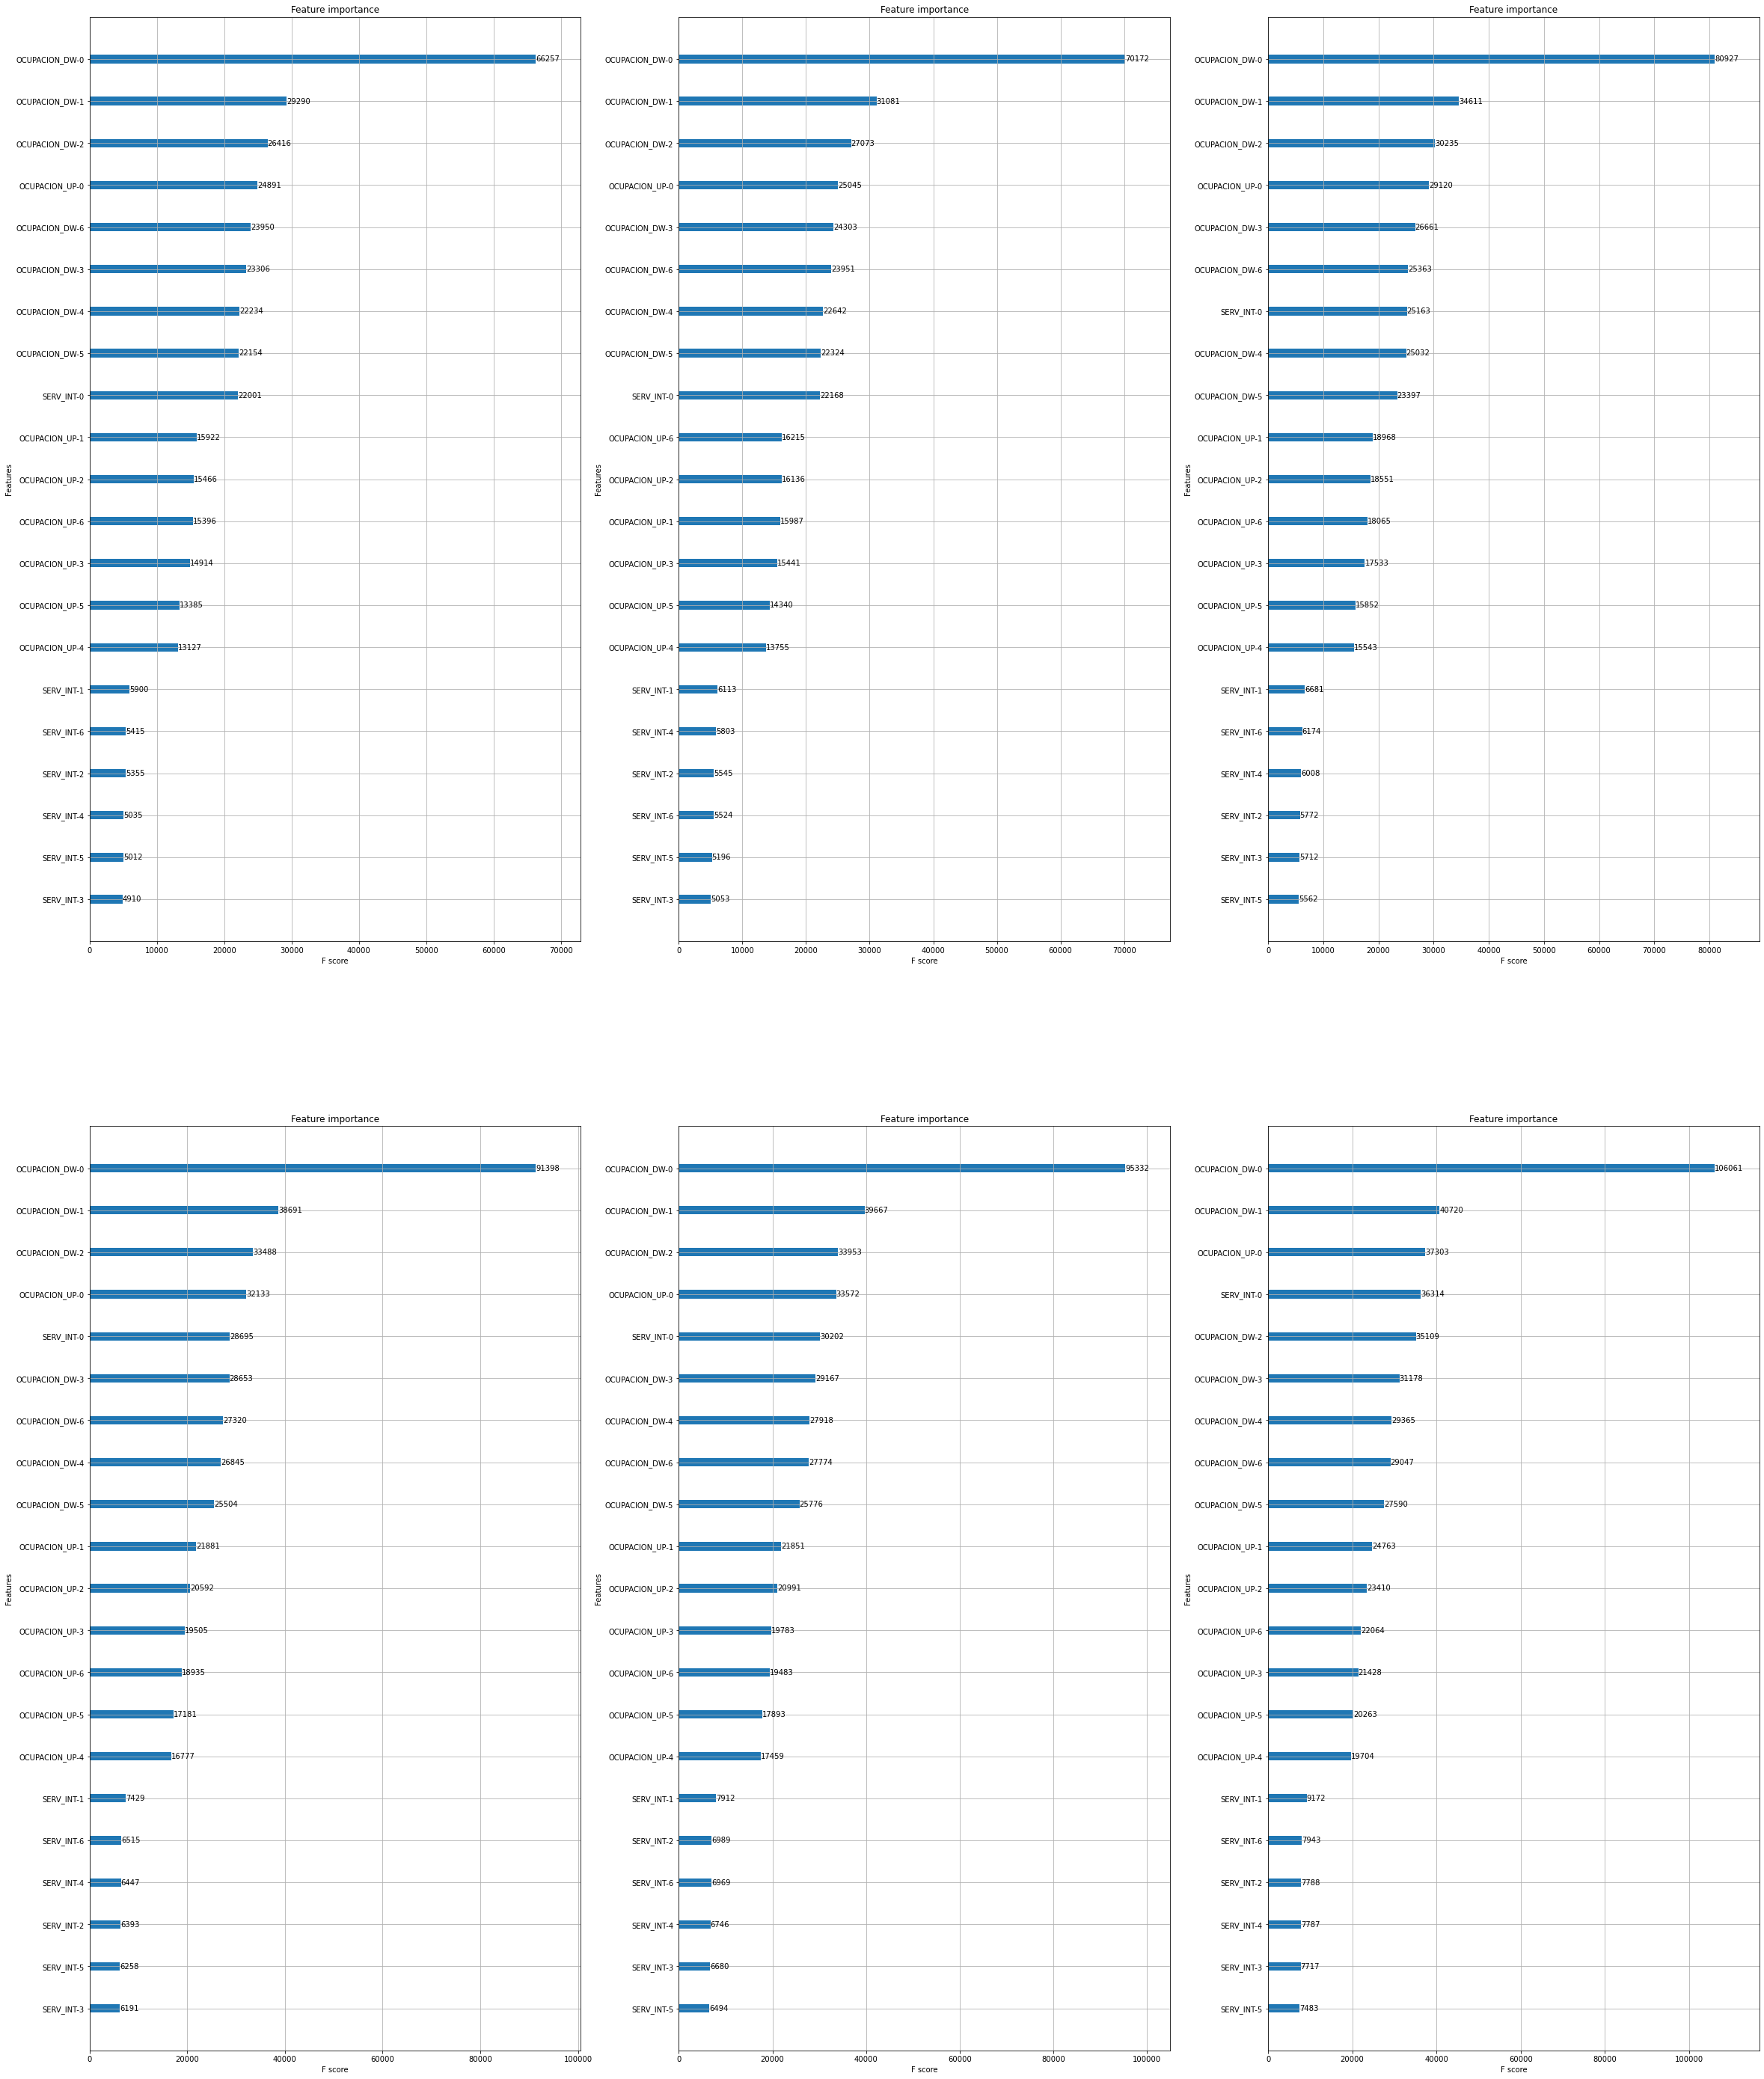

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(40,50))
i=0
for predVar in modelos:
    j=0    
    axes[i//3,i%3].set_title(predVar)    
    xgb.plot_importance(modelos[predVar]['modelo'],ax=axes[i//3,i%3]) 
    j=j+1
    i=i+1

#### Matrices de confusión

##### Semaforo

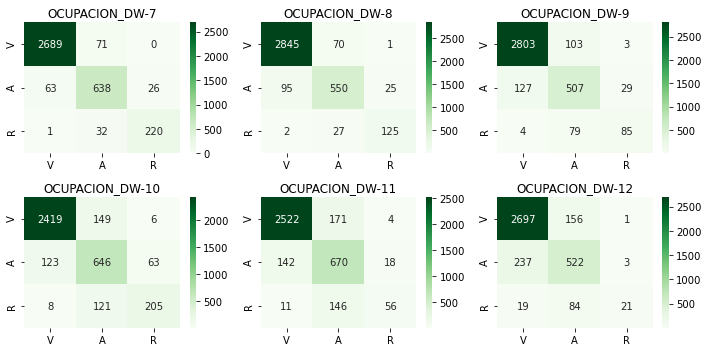

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5))
i=0
for predVar in modelos:
    y_test_sem = [semaforoVal(x) for x in y_test[predVar]]    
    y_test_p_sem=[semaforoVal(x) for x in modelos[predVar]['predictions']]
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem, labels=['V','A','R'])
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['V','A','R'], columns=['V','A','R'])
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

#####  Rojos

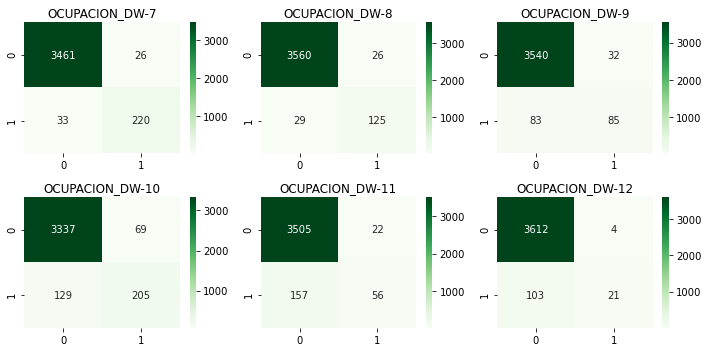

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5))
i=0
for predVar in modelos:    
    y_test_sem = [semaforoRojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoRojo(x) for x in modelos[predVar]['predictions']]
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem)
    matrizConfucionDF=pd.DataFrame(matrizConfucion)
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

##### Curva ROC y AUC

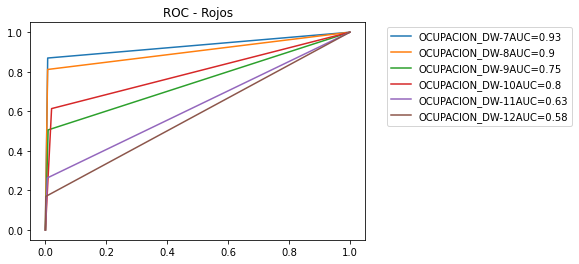

In [47]:
i=0
for predVar in modelos:
    j=0
    y_test_sem = [semaforoRojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoRojo(x) for x in modelos[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelos[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'AUC={}'.format(np.round(auc1, 2)))        
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title("ROC - Rojos");

##### ROC AMARILLOS

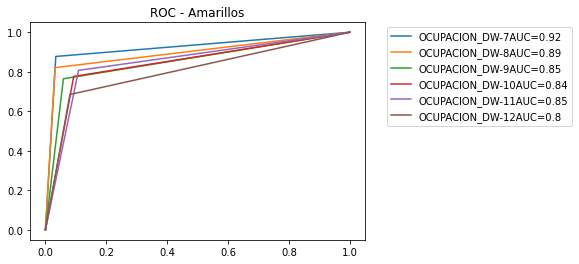

In [48]:
for predVar in modelos:        
    y_test_sem = [semaforoAmarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoAmarillo(x) for x in modelos[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelos[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title("ROC - Amarillos");

##### ROC Rojos y Amarillos

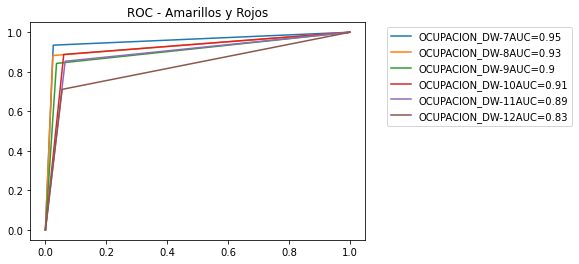

In [49]:
for predVar in modelos:    
    y_test_sem = [semaforoRojoAmarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoRojoAmarillo(x) for x in modelos[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelos[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'AUC={}'.format(np.round(auc1, 2)))           
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title("ROC - Amarillos y Rojos");

### LGBMClassifier

#### Agregar Semaforo a variable y

In [50]:
X_train, X_test, y_train, y_test = train_test_split(XvarC, yvar, test_size = 0.3, random_state = 86, shuffle= True)

In [51]:
modelosClass={}
X_train_Balanceadas={}
for yCol in yColClass:  
    count=y_train[yCol].value_counts()
    n_samples=int(count.max())
    over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_train, y_train[yCol],n_samples,t='minority'),k_neighbors=2)
    X_train_res, y_train_res= over_sampler.fit_resample(X_train,y_train[yCol])
    X_train_Balanceadas[yCol]=X_train_res
    
    print(yCol)
    y_test_aux=y_test[yCol]
    dicModelo={}        
    
    dicModelo['modelo']=LGBMClassifier(n_estimators=500, learning_rate=0.01, reg_alpha=1, reg_lambda=3, objective ='multiclass')
    dicModelo['modelo'].fit(X_train_res, y_train_res) # ajustamos los datos de entrenamiento

    dicModelo['predictions'] =dicModelo['modelo'].predict(X_test)
    dicModelo['explanation']=shap.TreeExplainer(dicModelo['modelo'])
    dicModelo['shap_values']=dicModelo['explanation'].shap_values(XvarC)    
    modelosClass[yCol]=dicModelo

OCUPACION_DW-7_sem2
OCUPACION_DW-8_sem2
OCUPACION_DW-9_sem2
OCUPACION_DW-10_sem2
OCUPACION_DW-11_sem2
OCUPACION_DW-12_sem2


In [82]:
#modelosClass['OCUPACION_DW-7_sem2']['modelo'].predict(X_test)

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [83]:
#X_test

mesAnt,CANT_CALL-0,CANT_CALL-1,CANT_CALL-2,CANT_CALL-3,CANT_CALL-4,CANT_CALL-5,CANT_CALL-6,CANT_USER-0,CANT_USER-1,CANT_USER-2,CANT_USER-3,CANT_USER-4,CANT_USER-5,CANT_USER-6,CONVERGENTE-0,CONVERGENTE-1,CONVERGENTE-2,CONVERGENTE-3,CONVERGENTE-4,CONVERGENTE-5,CONVERGENTE-6,MEDIANA_VEL-0,MEDIANA_VEL-1,MEDIANA_VEL-2,MEDIANA_VEL-3,MEDIANA_VEL-4,MEDIANA_VEL-5,MEDIANA_VEL-6,OCUPACION_DW-0,OCUPACION_DW-1,OCUPACION_DW-2,OCUPACION_DW-3,OCUPACION_DW-4,OCUPACION_DW-5,OCUPACION_DW-6,OCUPACION_UP-0,OCUPACION_UP-1,OCUPACION_UP-2,OCUPACION_UP-3,OCUPACION_UP-4,OCUPACION_UP-5,OCUPACION_UP-6,PROM_RENTA-0,PROM_RENTA-1,PROM_RENTA-2,PROM_RENTA-3,PROM_RENTA-4,PROM_RENTA-5,PROM_RENTA-6,PROM_VEL-0,PROM_VEL-1,PROM_VEL-2,PROM_VEL-3,PROM_VEL-4,PROM_VEL-5,PROM_VEL-6,RENTA-0,RENTA-1,RENTA-2,RENTA-3,RENTA-4,RENTA-5,RENTA-6,SERV_INT-0,SERV_INT-1,SERV_INT-2,SERV_INT-3,SERV_INT-4,SERV_INT-5,SERV_INT-6,SERV_TV-0,SERV_TV-1,SERV_TV-2,SERV_TV-3,SERV_TV-4,SERV_TV-5,SERV_TV-6,SERV_VOZ-0,SERV_VOZ-1,SERV_VOZ-2,SERV_VOZ-3,SERV_VOZ-4,SERV_VOZ-5,SERV_VOZ-6,VEL_10_25-0,VEL_10_25-1,VEL_10_25-2,VEL_10_25-3,VEL_10_25-4,VEL_10_25-5,VEL_10_25-6,VEL_30-0,VEL_30-1,VEL_30-2,VEL_30-3,VEL_30-4,VEL_30-5,VEL_30-6,VEL_40_50-0,VEL_40_50-1,VEL_40_50-2,VEL_40_50-3,VEL_40_50-4,VEL_40_50-5,VEL_40_50-6,VEL_MAX-0,VEL_MAX-1,VEL_MAX-2,VEL_MAX-3,VEL_MAX-4,VEL_MAX-5,VEL_MAX-6,VEL_MA_60-0,VEL_MA_60-1,VEL_MA_60-2,VEL_MA_60-3,VEL_MA_60-4,VEL_MA_60-5,VEL_MA_60-6,VEL_ME_8-0,VEL_ME_8-1,VEL_ME_8-2,VEL_ME_8-3,VEL_ME_8-4,VEL_ME_8-5,VEL_ME_8-6,VEL_MIN-0,VEL_MIN-1,VEL_MIN-2,VEL_MIN-3,VEL_MIN-4,VEL_MIN-5,VEL_MIN-6
COD_NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
41B2D,11.0,12.0,11.0,7.0,21.0,17.0,11.0,149.0,151.0,149.0,149.0,149.0,151.0,150.0,74.0,78.0,78.0,79.0,78.0,77.0,76.0,30.0,30.0,30.0,45.0,45.0,45.0,45.0,0.584726,0.587220,0.612604,0.586902,0.559536,0.584324,0.587507,0.337559,0.346047,0.308069,0.304389,0.300366,0.294576,0.248500,128925.0,129960.0,130013.0,129228.0,129027.0,130211.0,130464.0,43.0,45.0,46.0,51.0,53.0,56.0,59.0,19209845.0,19623948.0,19371997.0,19254953.0,19224972.0,19661801.0,19569623.0,149.0,151.0,149.0,149.0,149.0,151.0,150.0,138.0,139.0,138.0,139.0,138.0,138.0,138.0,128.0,132.0,130.0,130.0,130.0,131.0,131.0,49.0,48.0,41.0,32.0,30.0,25.0,22.0,35.0,34.0,33.0,26.0,25.0,27.0,24.0,28.0,30.0,36.0,47.0,45.0,48.0,50.0,150.0,150.0,150.0,180.0,180.0,180.0,180.0,35.0,38.0,38.0,43.0,48.0,50.0,53.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
52C,12.0,14.0,13.0,12.0,15.0,19.0,10.0,107.0,107.0,107.0,105.0,107.0,106.0,106.0,36.0,40.0,39.0,39.0,41.0,40.0,39.0,30.0,40.0,45.0,50.0,50.0,50.0,50.0,0.397876,0.400380,0.449639,0.459360,0.447600,0.502724,0.509924,0.297028,0.283811,0.337425,0.335350,0.303098,0.484958,0.425661,124850.0,126771.0,126286.0,126850.0,127280.0,126632.0,126970.0,44.0,45.0,49.0,55.0,56.0,57.0,58.0,13358950.0,13564496.0,13512638.0,13319261.0,13618933.0,13422989.0,13458794.0,107.0,107.0,107.0,105.0,107.0,106.0,106.0,97.0,98.0,98.0,96.0,98.0,97.0,97.0,101.0,101.0,102.0,101.0,103.0,102.0,102.0,35.0,30.0,18.0,14.0,12.0,11.0,11.0,19.0,22.0,23.0,18.0,19.0,18.0,17.0,28.0,32.0,42.0,43.0,43.0,43.0,44.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,24.0,22.0,24.0,30.0,33.0,34.0,34.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,10.0,10.0,10.0,10.0,10.0
NY1,23.0,34.0,34.0,44.0,34.0,32.0,28.0,408.0,403.0,397.0,387.0,397.0,392.0,404.0,135.0,135.0,140.0,139.0,143.0,149.0,152.0,30.0,30.0,30.0,45.0,45.0,45.0,45.0,0.438831,0.450646,0.472485,0.469108,0.514603,0.516667,0.519030,0.586465,0.552460,0.565150,0.683676,0.677071,0.702690,0.625702,123910.0,121896.0,119830.0,119021.0,121811.0,122587.0,123242.0,40.0,41.0,44.0,50.0,52.0,54.0,55.0,50555143.0,49124144.0,47572437.0,46061308.0,48358879.0,48054157.0,49789773.0,408.0,403.0,397.0,387.0,397.0,392.0,404.0,370.0,363.0,358.0,348.0,360.0,358.0,367.0,361.0,355.0,350.0,344.0,354.0,349.0,359.0,117.0,97.0,76.0,51.0,47.0,44.0,37.0,128.0,141.0,123.0,101.0,90.0,85.0,89.0,88.0,9

In [92]:
#X_train

mesAnt,CANT_CALL-0,CANT_CALL-1,CANT_CALL-2,CANT_CALL-3,CANT_CALL-4,CANT_CALL-5,CANT_CALL-6,CANT_USER-0,CANT_USER-1,CANT_USER-2,CANT_USER-3,CANT_USER-4,CANT_USER-5,CANT_USER-6,CONVERGENTE-0,CONVERGENTE-1,CONVERGENTE-2,CONVERGENTE-3,CONVERGENTE-4,CONVERGENTE-5,CONVERGENTE-6,MEDIANA_VEL-0,MEDIANA_VEL-1,MEDIANA_VEL-2,MEDIANA_VEL-3,MEDIANA_VEL-4,MEDIANA_VEL-5,MEDIANA_VEL-6,OCUPACION_DW-0,OCUPACION_DW-1,OCUPACION_DW-2,OCUPACION_DW-3,OCUPACION_DW-4,OCUPACION_DW-5,OCUPACION_DW-6,OCUPACION_UP-0,OCUPACION_UP-1,OCUPACION_UP-2,OCUPACION_UP-3,OCUPACION_UP-4,OCUPACION_UP-5,OCUPACION_UP-6,PROM_RENTA-0,PROM_RENTA-1,PROM_RENTA-2,PROM_RENTA-3,PROM_RENTA-4,PROM_RENTA-5,PROM_RENTA-6,PROM_VEL-0,PROM_VEL-1,PROM_VEL-2,PROM_VEL-3,PROM_VEL-4,PROM_VEL-5,PROM_VEL-6,RENTA-0,RENTA-1,RENTA-2,RENTA-3,RENTA-4,RENTA-5,RENTA-6,SERV_INT-0,SERV_INT-1,SERV_INT-2,SERV_INT-3,SERV_INT-4,SERV_INT-5,SERV_INT-6,SERV_TV-0,SERV_TV-1,SERV_TV-2,SERV_TV-3,SERV_TV-4,SERV_TV-5,SERV_TV-6,SERV_VOZ-0,SERV_VOZ-1,SERV_VOZ-2,SERV_VOZ-3,SERV_VOZ-4,SERV_VOZ-5,SERV_VOZ-6,VEL_10_25-0,VEL_10_25-1,VEL_10_25-2,VEL_10_25-3,VEL_10_25-4,VEL_10_25-5,VEL_10_25-6,VEL_30-0,VEL_30-1,VEL_30-2,VEL_30-3,VEL_30-4,VEL_30-5,VEL_30-6,VEL_40_50-0,VEL_40_50-1,VEL_40_50-2,VEL_40_50-3,VEL_40_50-4,VEL_40_50-5,VEL_40_50-6,VEL_MAX-0,VEL_MAX-1,VEL_MAX-2,VEL_MAX-3,VEL_MAX-4,VEL_MAX-5,VEL_MAX-6,VEL_MA_60-0,VEL_MA_60-1,VEL_MA_60-2,VEL_MA_60-3,VEL_MA_60-4,VEL_MA_60-5,VEL_MA_60-6,VEL_ME_8-0,VEL_ME_8-1,VEL_ME_8-2,VEL_ME_8-3,VEL_ME_8-4,VEL_ME_8-5,VEL_ME_8-6,VEL_MIN-0,VEL_MIN-1,VEL_MIN-2,VEL_MIN-3,VEL_MIN-4,VEL_MIN-5,VEL_MIN-6
COD_NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7A2,10.0,8.0,14.0,14.0,12.0,15.0,11.0,91.0,90.0,91.0,91.0,88.0,87.0,88.0,31.0,32.0,32.0,33.0,34.0,35.0,34.0,50.0,50.0,50.0,60.0,60.0,75.0,75.0,0.192328,0.192945,0.190537,0.173688,0.169119,0.181362,0.184646,0.450880,0.376127,0.377022,0.445383,0.432681,0.454874,0.426605,165680.0,162408.0,165435.0,163465.0,165186.0,165588.0,164167.0,68.0,69.0,71.0,76.0,78.0,80.0,81.0,15076885.0,14616687.0,15054564.0,14875324.0,14536376.0,14406161.0,14446662.0,91.0,90.0,91.0,91.0,88.0,87.0,88.0,60.0,60.0,60.0,61.0,59.0,58.0,58.0,79.0,78.0,78.0,77.0,75.0,74.0,76.0,17.0,12.0,9.0,6.0,6.0,5.0,5.0,8.0,11.0,14.0,11.0,10.0,9.0,8.0,26.0,24.0,23.0,25.0,22.0,22.0,23.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,39.0,42.0,44.0,48.0,49.0,50.0,51.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
6CB,10.0,3.0,11.0,8.0,9.0,7.0,12.0,94.0,91.0,90.0,90.0,96.0,97.0,96.0,46.0,43.0,44.0,46.0,50.0,49.0,48.0,30.0,30.0,30.0,43.0,45.0,45.0,45.0,0.440151,0.499557,0.572248,0.507884,0.523901,0.555132,0.548888,0.499760,0.456920,0.473550,0.476010,0.458489,0.471549,0.427909,119626.0,117717.0,117621.0,116541.0,117674.0,120946.0,123319.0,34.0,37.0,39.0,43.0,46.0,48.0,49.0,11244808.0,10712248.0,10585859.0,10488700.0,11296688.0,11731718.0,11838642.0,94.0,91.0,90.0,90.0,96.0,97.0,96.0,87.0,84.0,83.0,82.0,89.0,88.0,88.0,84.0,81.0,80.0,78.0,85.0,86.0,86.0,36.0,28.0,21.0,11.0,11.0,8.0,8.0,29.0,26.0,28.0,29.0,28.0,27.0,27.0,18.0,24.0,27.0,33.0,35.0,39.0,37.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,10.0,12.0,13.0,16.0,21.0,22.0,23.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
ZR3,4.0,7.0,4.0,3.0,6.0,4.0,1.0,79.0,79.0,84.0,81.0,77.0,79.0,76.0,37.0,37.0,37.0,35.0,33.0,34.0,33.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,0.719145,0.771250,0.794413,0.764710,0.801647,0.807801,0.797606,0.169751,0.176619,0.168386,0.155231,0.166563,0.167604,0.151330,105400.0,101721.0,102954.0,100215.0,101503.0,101355.0,100988.0,27.0,26.0,28.0,31.0,32.0,33.0,33.0,8326637.0,8035938.0,8648152.0,8117402.0,7815730.0,8007041.0,7675101.0,79.0,79.0,84.0,81.0,77.0,79.0,76.0,74.0,73.0,78.0,74.0,69.0,71.0,68.0,72.0,72.0,79.0,74.0,69.0,71.0,69.0,29.0,30.0,27.0,22.0,20.0,18.0,18.0,35.0,38.0,41.0,34.0,34.0,35.0,31.0,9.0,9.0,11.0,21.0,18.0,20.0,20.0,75.0,80.0,100.0,100.0,150.0,150.0,150.0,3.0,1.0,2.0,2.0,3.0,4.0,4.0,3.0,1.0,3.0,2.0,2.0,2.0,3.0,5

In [84]:
#len(X_test.columns)

133

In [85]:
#tablaAnalisisTotalNpC

mesAnt,OCUPACION_DW-0,OCUPACION_DW-1,OCUPACION_DW-2,OCUPACION_DW-3,OCUPACION_DW-4,OCUPACION_DW-5,OCUPACION_DW-6,OCUPACION_UP-0,OCUPACION_UP-1,OCUPACION_UP-2,OCUPACION_UP-3,OCUPACION_UP-4,OCUPACION_UP-5,OCUPACION_UP-6,CANT_USER-0,CANT_USER-1,CANT_USER-2,CANT_USER-3,CANT_USER-4,CANT_USER-5,CANT_USER-6,PROM_VEL-0,PROM_VEL-1,PROM_VEL-2,PROM_VEL-3,PROM_VEL-4,PROM_VEL-5,PROM_VEL-6,MEDIANA_VEL-0,MEDIANA_VEL-1,MEDIANA_VEL-2,MEDIANA_VEL-3,MEDIANA_VEL-4,MEDIANA_VEL-5,MEDIANA_VEL-6,VEL_ME_8-0,VEL_ME_8-1,VEL_ME_8-2,VEL_ME_8-3,VEL_ME_8-4,VEL_ME_8-5,VEL_ME_8-6,VEL_10_25-0,VEL_10_25-1,VEL_10_25-2,VEL_10_25-3,VEL_10_25-4,VEL_10_25-5,VEL_10_25-6,VEL_30-0,VEL_30-1,VEL_30-2,VEL_30-3,VEL_30-4,VEL_30-5,VEL_30-6,VEL_40_50-0,VEL_40_50-1,VEL_40_50-2,VEL_40_50-3,VEL_40_50-4,VEL_40_50-5,VEL_40_50-6,VEL_MA_60-0,VEL_MA_60-1,VEL_MA_60-2,VEL_MA_60-3,VEL_MA_60-4,VEL_MA_60-5,VEL_MA_60-6,VEL_MAX-0,VEL_MAX-1,VEL_MAX-2,VEL_MAX-3,VEL_MAX-4,VEL_MAX-5,VEL_MAX-6,VEL_MIN-0,VEL_MIN-1,VEL_MIN-2,VEL_MIN-3,VEL_MIN-4,VEL_MIN-5,VEL_MIN-6,RENTA-0,RENTA-1,RENTA-2,RENTA-3,RENTA-4,RENTA-5,RENTA-6,PROM_RENTA-0,PROM_RENTA-1,PROM_RENTA-2,PROM_RENTA-3,PROM_RENTA-4,PROM_RENTA-5,PROM_RENTA-6,CONVERGENTE-0,CONVERGENTE-1,CONVERGENTE-2,CONVERGENTE-3,CONVERGENTE-4,CONVERGENTE-5,CONVERGENTE-6,SERV_INT-0,SERV_INT-1,SERV_INT-2,SERV_INT-3,SERV_INT-4,SERV_INT-5,SERV_INT-6,SERV_TV-0,SERV_TV-1,SERV_TV-2,SERV_TV-3,SERV_TV-4,SERV_TV-5,SERV_TV-6,SERV_VOZ-0,SERV_VOZ-1,SERV_VOZ-2,SERV_VOZ-3,SERV_VOZ-4,SERV_VOZ-5,SERV_VOZ-6,CANT_CALL-0,CANT_CALL-1,CANT_CALL-2,CANT_CALL-3,CANT_CALL-4,CANT_CALL-5,CANT_CALL-6
COD_NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,28.0,24.0,24.0,26.0,26.0,25.0,24.0,39.0,58.0,76.0,80.0,99.0,103.0,104.0,38.0,45.0,50.0,50.0,90.0,100.0,100.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,8.0,8.0,7.0,8.0,3.0,1.0,0.0,11.0,8.0,6.0,3.0,5.0,4.0,3.0,3.0,5.0,8.0,11.0,15.0,17.0,18.0,100.0,160.0,200.0,200.0,200.0,200.0,200.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2935731.0,2499040.0,2564063.0,2720588.0,2856137.0,2701846.0,2687786.0,104848.0,104127.0,106836.0,104638.0,109851.0,108074.0,111991.0,9.0,6.0,7.0,7.0,7.0,7.0,7.0,28.0,24.0,24.0,26.0,26.0,25.0,24.0,24.0,20.0,20.0,22.0,22.0,21.0,21.0,21.0,18.0,18.0,21.0,21.0,20.0,19.0,1.0,3.0,0.0,1.0,0.0,1.0,2.0
01S,0.395358,0.402865,0.347061,0.401564,0.373240,0.348979,0.432986,0.278147,0.302325,0.298426,0.290753,0.339117,0.306406,0.269256,159.0,163.0,160.0,167.0,171.0,170.0,177.0,38.0,41.0,42.0,42.0,83.0,92.0,96.0,45.0,45.0,45.0,45.0,50.0,78.0,100.0,43.0,44.0,41.0,42.0,40.0,39.0,38.0,6.0,6.0,6.0,6.0,6.0,2.0,2.0,27.0,23.0,24.0,31.0,23.0,16.0,18.0,58.0,56.0,53.0,51.0,23.0,12.0,10.0,25.0,34.0,36.0,37.0,79.0,101.0,109.0,150.0,150.0,150.0,160.0,400.0,400.0,400.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,14246613.0,14785962.0,14604470.0,15314897.0,15967564.0,15722013.0,16439873.0,89601.0,90711.0,91278.0,91706.0,93378.0,92482.0,92881.0,86.0,89.0,86.0,85.0,84.0,90.0,89.0,159.0,163.0,160.0,167.0,171.0,170.0,177.0,119.0,126.0,124.0,129.0,131.0,128.0,130.0,129.0,134.0,130.0,137.0,143.0,137.0,140.0,22.0,13.0,9.0,8.0,15.0,12.0,13.0
02J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,11.0,12.0,12.0,12.0,13.0,14.0,15.0,48.0,73.0,73.0,73.0,72.0,88.0,92.0,45.0,50.0,50.0,50.0,50.0,75.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,5.0,5.0,5.0,6.0,11.0,12.0,100.0,160.0,160.0,160.0,160.0,160.0,160.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1211319.0,1317225.0,1297227.0,1290278.0,1445078.0,1554978.0,1697728.0,110120.0,109769.0,108102.0,107523.0,111160.0,111070.0,113182.0,5.0,5.0,5.0,5.0,6.0,7.0,6.0,11.0,12.0,12.0,12.0,13.0,14.0,15.0,8.0,9.0,9.0,9.0,10.0,11.0,12.0,10.0,11.0,11.0,11.0,11.0,12.0,12.0,1.0,1.0,1.0,0.0,1.0,0.0

In [91]:
#a=modelosClass['OCUPACION_DW-7_sem2']['modelo'].predict(X_train)
#unique, counts = np.unique(a, return_counts=True)
#dict(zip(unique, counts))

{0: 6363, 1: 1662, 2: 701}

In [93]:
#a=modelosClass['OCUPACION_DW-7_sem2']['modelo'].predict(X_test)
#unique, counts = np.unique(a, return_counts=True)
#dict(zip(unique, counts))

{0: 2683, 1: 765, 2: 292}

In [94]:
#a=modelosClass['OCUPACION_DW-7_sem2']['modelo'].predict(tablaAnalisisTotalNpC)
#unique, counts = np.unique(a, return_counts=True)
#dict(zip(unique, counts))

{2: 12668}

In [95]:
#a=modelosClass['OCUPACION_DW-7_sem2']['modelo'].predict(tablaAnalisisTotalNpC[cols_xC])
#unique, counts = np.unique(a, return_counts=True)
#dict(zip(unique, counts))

{0: 9091, 1: 3108, 2: 469}

In [52]:
#XvarC

mesAnt,CANT_CALL-0,CANT_CALL-1,CANT_CALL-2,CANT_CALL-3,CANT_CALL-4,CANT_CALL-5,CANT_CALL-6,CANT_USER-0,CANT_USER-1,CANT_USER-2,...,VEL_ME_8-4,VEL_ME_8-5,VEL_ME_8-6,VEL_MIN-0,VEL_MIN-1,VEL_MIN-2,VEL_MIN-3,VEL_MIN-4,VEL_MIN-5,VEL_MIN-6
COD_NODO,,,,,,,,,,,,,,,,,,,,,
01J,0.0,0.0,2.0,2.0,1.0,1.0,0.0,24.0,27.0,27.0,...,2.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
01S,10.0,12.0,14.0,16.0,21.0,5.0,5.0,77.0,96.0,115.0,...,46.0,43.0,47.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0
02J,0.0,0.0,1.0,3.0,2.0,2.0,0.0,14.0,13.0,12.0,...,0.0,0.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
02S,5.0,5.0,9.0,9.0,11.0,6.0,7.0,61.0,77.0,93.0,...,36.0,41.0,39.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
03J,2.0,0.0,0.0,1.0,4.0,0.0,1.0,26.0,24.0,24.0,...,1.0,1.0,1.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZVD,31.0,36.0,37.0,50.0,44.0,39.0,31.0,465.0,476.0,482.0,...,11.0,11.0,9.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
ZVG,21.0,22.0,27.0,27.0,28.0,19.0,16.0,336.0,337.0,335.0,...,32.0,32.0,32.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0
ZVS,38.0,37.0,43.0,51.0,45.0,31.0,22.0,496.0,485.0,477.0,...,57.0,54.0,55.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


 #### Variables Explicativas

In [53]:
#Mostrar importancia de variable, aumenta 15 min el tiempo de procesamiento
#for predVar in modelosClass:       
#    print(predVar)    
#    df2Feature_importanceClass(X_train_Balanceadas[predVar],modelosClass[predVar]['modelo'],predVar)  

#### Matrices de Confusión

##### Semaforo

OCUPACION_DW-7_sem2
exactitud: 0.9323529411764706
sensibilidad  0 :  0.9528985507246377
especificidad  0 :  0.9459183673469388
sensibilidad  1 :  0.8528198074277854
especificidad  1 :  0.9518752074344508
sensibilidad  2 :  0.9367588932806324
especificidad  2 :  0.9842271293375394
OCUPACION_DW-8_sem2
exactitud: 0.922192513368984
sensibilidad  0 :  0.9554183813443072
especificidad  0 :  0.9016990291262136
sensibilidad  1 :  0.7880597014925373
especificidad  1 :  0.9534201954397394
sensibilidad  2 :  0.8766233766233766
especificidad  2 :  0.9813162297824874
OCUPACION_DW-9_sem2
exactitud: 0.877807486631016
sensibilidad  0 :  0.9250601581299416
especificidad  0 :  0.8796630565583634
sensibilidad  1 :  0.7194570135746606
especificidad  1 :  0.9177770555736107
sensibilidad  2 :  0.6845238095238095
especificidad  2 :  0.9708846584546472
OCUPACION_DW-10_sem2
exactitud: 0.8409090909090909
sensibilidad  0 :  0.8986013986013986
especificidad  0 :  0.8970840480274442
sensibilidad  1 :  0.7211538461

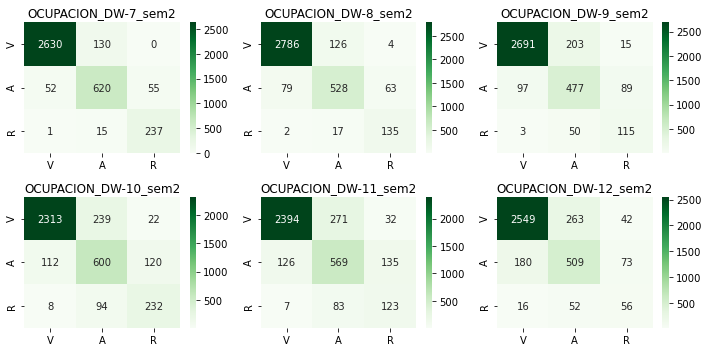

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5))
i=0
for predVar in modelosClass:        
    y_test_sem = y_test[predVar]
    y_test_p_sem=modelosClass[predVar]['predictions']
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem)
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['V','A','R'], columns=['V','A','R'])
    print(predVar)
    medidasEvaluacion(matrizConfucion)
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

##### Rojos

OCUPACION_DW-7_sem2
OCUPACION_DW-8_sem2
OCUPACION_DW-9_sem2
OCUPACION_DW-10_sem2
OCUPACION_DW-11_sem2
OCUPACION_DW-12_sem2


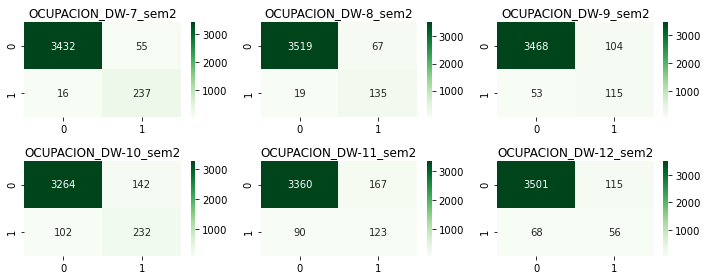

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,4))
i=0
for predVar in modelosClass:  
    print(predVar)
    y_test_sem = [semaforoNum2Rojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2Rojo(x) for x in modelosClass[predVar]['predictions']]
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem)
    matrizConfucionDF=pd.DataFrame(matrizConfucion)
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

#####  Curva ROC

##### Solo Rojos

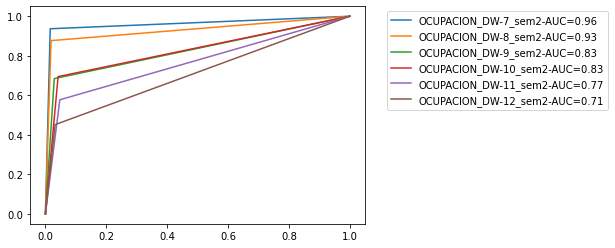

In [56]:
for predVar in modelosClass:        
    y_test_sem = [semaforoNum2Rojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2Rojo(x) for x in modelosClass[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelosClass[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'-'+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

##### Solo Amarillos

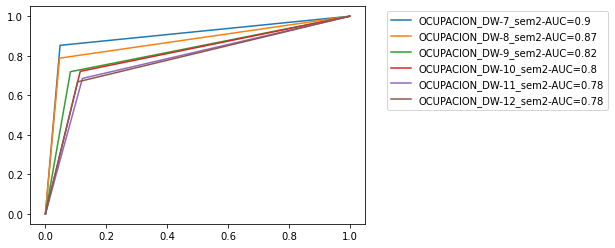

In [57]:
for predVar in modelosClass:        
    y_test_sem = [semaforoNum2Amarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2Amarillo(x) for x in modelosClass[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelosClass[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'-'+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

##### Rojos y amarillos

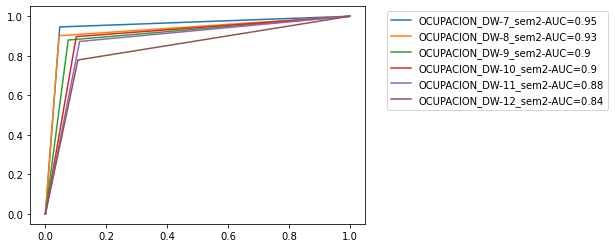

In [58]:
for predVar in modelosClass:        
    y_test_sem = [semaforoNum2RojoAmarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2RojoAmarillo(x) for x in modelosClass[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelosClass[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'-'+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

###  NUEVAS PREDICCIONES

In [96]:
data_ocupacionNp=data_ocupacion.copy()
data_ocupacionNpC=data_ocupacionC.copy()

In [97]:
periodos_x=6
fechaMaxima=data_ocupacionNp['FECHA'].max()
fechaInicialNp=fechaMaxima + relativedelta(months=-1*periodos_x)

In [98]:
data_ocupacionNp=data_ocupacionNp[data_ocupacionNp['FECHA']>=fechaInicialNp]
data_ocupacionNpC=data_ocupacionNpC[data_ocupacionNpC['FECHA']>=fechaInicialNp]
data_ocupacionNp['mesAnt']=(periodos_x)-diff_month(fechaMaxima,data_ocupacionNp['FECHA'])
data_ocupacionNpC['mesAnt']=(periodos_x)-diff_month(fechaMaxima,data_ocupacionNpC['FECHA'])

In [99]:
data_ocupacionNp['FECHA'].max()

Timestamp('2021-07-01 00:00:00')

In [100]:
data_ocupacionNp['FECHA'].min()

Timestamp('2021-01-01 00:00:00')

In [101]:
colsNp=data_ocupacionNp.columns
colsNp=colsNp[2:-1]
colsNpC=data_ocupacionNpC.columns
colsNpC=colsNpC[2:-1]

In [102]:
#Tabla para regresión
cols_xNp=[]
for i, col in enumerate(colsNp):
    tablaAnalisisNp = pd.pivot_table(data_ocupacionNp.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisisNp.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisisNp.columns}, inplace=True)    
    cols_xNp=cols_xNp+[(col+"-"+str(x)) for x in range(0,periodos_x+1)]    
    if i==0:
        tablaAnalisisTotalNp = tablaAnalisisNp
    else:
        tablaAnalisisTotalNp = tablaAnalisisTotalNp.merge(tablaAnalisisNp, how='outer', on='COD_NODO')

In [103]:
#Tabla para clasificación
cols_xNpC=[]
for i, col in enumerate(colsNpC):
    tablaAnalisisNpC = pd.pivot_table(data_ocupacionNpC.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisisNpC.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisisNpC.columns}, inplace=True)    
    cols_xNpC=cols_xNpC+[(col+"-"+str(x)) for x in range(0,periodos_x+1)]    
    if i==0:
        tablaAnalisisTotalNpC = tablaAnalisisNpC
    else:
        tablaAnalisisTotalNpC = tablaAnalisisTotalNpC.merge(tablaAnalisisNpC, how='outer', on='COD_NODO')

In [106]:
tablaAnalisisTotalNp=tablaAnalisisTotalNp.dropna()
tablaAnalisisTotalNpC=tablaAnalisisTotalNpC.dropna()

In [107]:
tablaResultados=tablaAnalisisTotalNp.copy()

#### Resultados 

In [109]:
for predVar in modelos:
    print(predVar)
    tablaResultados[predVar+'_pR']=modelos[predVar]['modelo'].predict(tablaAnalisisTotalNp[cols_x])
    tablaResultados[predVar+'_pR_Sem']=tablaResultados[predVar+'_pR'].apply(semaforoVal)    

OCUPACION_DW-7
OCUPACION_DW-8
OCUPACION_DW-9
OCUPACION_DW-10
OCUPACION_DW-11
OCUPACION_DW-12


In [71]:
#tablaAnalisisTotalNpC

mesAnt,OCUPACION_DW-0,OCUPACION_DW-1,OCUPACION_DW-2,OCUPACION_DW-3,OCUPACION_DW-4,OCUPACION_DW-5,OCUPACION_DW-6,OCUPACION_UP-0,OCUPACION_UP-1,OCUPACION_UP-2,...,SERV_VOZ-4,SERV_VOZ-5,SERV_VOZ-6,CANT_CALL-0,CANT_CALL-1,CANT_CALL-2,CANT_CALL-3,CANT_CALL-4,CANT_CALL-5,CANT_CALL-6
COD_NODO,,,,,,,,,,,,,,,,,,,,,
01J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,...,21.0,20.0,19.0,1.0,3.0,0.0,1.0,0.0,1.0,2.0
01S,0.395358,0.402865,0.347061,0.401564,0.373240,0.348979,0.432986,0.278147,0.302325,0.298426,...,143.0,137.0,140.0,22.0,13.0,9.0,8.0,15.0,12.0,13.0
02J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,...,11.0,12.0,12.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0
02S,0.395358,0.402865,0.347061,0.401564,0.373240,0.348979,0.432986,0.182169,0.201613,0.286283,...,129.0,125.0,127.0,9.0,6.0,7.0,4.0,18.0,10.0,7.0
03J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,...,26.0,26.0,26.0,4.0,4.0,1.0,1.0,1.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZVD,0.809452,0.693191,0.606031,0.623811,0.630313,0.536716,0.614113,0.658396,0.698507,0.597221,...,361.0,351.0,349.0,30.0,23.0,28.0,18.0,15.0,21.0,24.0
ZVG,0.320684,0.291726,0.255091,0.271547,0.288601,0.265490,0.294397,0.260581,0.343077,0.333606,...,267.0,259.0,261.0,18.0,17.0,11.0,11.0,14.0,10.0,14.0
ZVS,0.298943,0.278718,0.299920,0.347705,0.352078,0.294876,0.286604,0.535179,0.581698,0.550249,...,404.0,407.0,402.0,33.0,24.0,29.0,17.0,15.0,28.0,16.0


In [72]:
#tablaAnalisisTotalNpC

mesAnt,OCUPACION_DW-0,OCUPACION_DW-1,OCUPACION_DW-2,OCUPACION_DW-3,OCUPACION_DW-4,OCUPACION_DW-5,OCUPACION_DW-6,OCUPACION_UP-0,OCUPACION_UP-1,OCUPACION_UP-2,...,SERV_VOZ-4,SERV_VOZ-5,SERV_VOZ-6,CANT_CALL-0,CANT_CALL-1,CANT_CALL-2,CANT_CALL-3,CANT_CALL-4,CANT_CALL-5,CANT_CALL-6
COD_NODO,,,,,,,,,,,,,,,,,,,,,
01J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,...,21.0,20.0,19.0,1.0,3.0,0.0,1.0,0.0,1.0,2.0
01S,0.395358,0.402865,0.347061,0.401564,0.373240,0.348979,0.432986,0.278147,0.302325,0.298426,...,143.0,137.0,140.0,22.0,13.0,9.0,8.0,15.0,12.0,13.0
02J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,...,11.0,12.0,12.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0
02S,0.395358,0.402865,0.347061,0.401564,0.373240,0.348979,0.432986,0.182169,0.201613,0.286283,...,129.0,125.0,127.0,9.0,6.0,7.0,4.0,18.0,10.0,7.0
03J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,...,26.0,26.0,26.0,4.0,4.0,1.0,1.0,1.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZVD,0.809452,0.693191,0.606031,0.623811,0.630313,0.536716,0.614113,0.658396,0.698507,0.597221,...,361.0,351.0,349.0,30.0,23.0,28.0,18.0,15.0,21.0,24.0
ZVG,0.320684,0.291726,0.255091,0.271547,0.288601,0.265490,0.294397,0.260581,0.343077,0.333606,...,267.0,259.0,261.0,18.0,17.0,11.0,11.0,14.0,10.0,14.0
ZVS,0.298943,0.278718,0.299920,0.347705,0.352078,0.294876,0.286604,0.535179,0.581698,0.550249,...,404.0,407.0,402.0,33.0,24.0,29.0,17.0,15.0,28.0,16.0


In [73]:
#tablaAnalisisTotalNpC.iloc[:1]

mesAnt,OCUPACION_DW-0,OCUPACION_DW-1,OCUPACION_DW-2,OCUPACION_DW-3,OCUPACION_DW-4,OCUPACION_DW-5,OCUPACION_DW-6,OCUPACION_UP-0,OCUPACION_UP-1,OCUPACION_UP-2,...,SERV_VOZ-4,SERV_VOZ-5,SERV_VOZ-6,CANT_CALL-0,CANT_CALL-1,CANT_CALL-2,CANT_CALL-3,CANT_CALL-4,CANT_CALL-5,CANT_CALL-6
COD_NODO,,,,,,,,,,,,,,,,,,,,,
01J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.35057,0.156491,0.202359,0.216276,...,21.0,20.0,19.0,1.0,3.0,0.0,1.0,0.0,1.0,2.0


In [74]:
#modelosClass['OCUPACION_DW-7_sem2']['modelo'].predict(tablaAnalisisTotalNpC.iloc[:1])

array([2], dtype=int64)

In [111]:
for predVar in modelosClass:
    print(predVar)
    tablaResultados[predVar+'_pC']=modelosClass[predVar]['modelo'].predict(tablaAnalisisTotalNpC[cols_xC])
    tablaResultados[predVar+'_pC']=tablaResultados[predVar+'_pC'].apply(semaforoNum2Val)    

OCUPACION_DW-7_sem2
OCUPACION_DW-8_sem2
OCUPACION_DW-9_sem2
OCUPACION_DW-10_sem2
OCUPACION_DW-11_sem2
OCUPACION_DW-12_sem2


In [112]:
import pandas as pd
pd.set_option('display.max_columns', None)
tablaResultados.head(10)

mesAnt,OCUPACION_DW-0,OCUPACION_DW-1,OCUPACION_DW-2,OCUPACION_DW-3,OCUPACION_DW-4,OCUPACION_DW-5,OCUPACION_DW-6,OCUPACION_UP-0,OCUPACION_UP-1,OCUPACION_UP-2,OCUPACION_UP-3,OCUPACION_UP-4,OCUPACION_UP-5,OCUPACION_UP-6,SERV_INT-0,SERV_INT-1,SERV_INT-2,SERV_INT-3,SERV_INT-4,SERV_INT-5,SERV_INT-6,OCUPACION_DW-7_pR,OCUPACION_DW-7_pR_Sem,OCUPACION_DW-8_pR,OCUPACION_DW-8_pR_Sem,OCUPACION_DW-9_pR,OCUPACION_DW-9_pR_Sem,OCUPACION_DW-10_pR,OCUPACION_DW-10_pR_Sem,OCUPACION_DW-11_pR,OCUPACION_DW-11_pR_Sem,OCUPACION_DW-12_pR,OCUPACION_DW-12_pR_Sem,OCUPACION_DW-7_sem2_pC,OCUPACION_DW-8_sem2_pC,OCUPACION_DW-9_sem2_pC,OCUPACION_DW-10_sem2_pC,OCUPACION_DW-11_sem2_pC,OCUPACION_DW-12_sem2_pC
COD_NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,28.0,24.0,24.0,26.0,26.0,25.0,24.0,0.373000,V,0.342128,V,0.377587,V,0.398850,V,0.429511,V,0.402187,V,V,V,V,V,V,V
01S,0.395358,0.402865,0.347061,0.401564,0.373240,0.348979,0.432986,0.278147,0.302325,0.298426,0.290753,0.339117,0.306406,0.269256,159.0,163.0,160.0,167.0,171.0,170.0,177.0,0.442048,V,0.432223,V,0.470374,V,0.526327,V,0.516793,V,0.535028,V,V,V,V,V,V,V
02J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,11.0,12.0,12.0,12.0,13.0,14.0,15.0,0.371358,V,0.344051,V,0.376142,V,0.401348,V,0.429674,V,0.416324,V,V,V,V,V,V,V
02S,0.395358,0.402865,0.347061,0.401564,0.373240,0.348979,0.432986,0.182169,0.201613,0.286283,0.300031,0.301526,0.243914,0.227977,135.0,135.0,138.0,146.0,148.0,144.0,148.0,0.432886,V,0.432994,V,0.467296,V,0.531377,V,0.519288,V,0.540635,V,V,V,V,V,V,V
03J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,32.0,31.0,32.0,32.0,32.0,32.0,30.0,0.373789,V,0.345234,V,0.377764,V,0.399739,V,0.432240,V,0.422675,V,V,V,V,V,V,V
04J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,18.0,19.0,20.0,19.0,19.0,21.0,20.0,0.373029,V,0.343444,V,0.377028,V,0.399038,V,0.430894,V,0.418702,V,V,V,V,V,V,V
05J,0.273088,0.269397,0.283512,0.299967,0.302036,0.318871,0.289796,0.269176,0.392237,0.320807,0.306752,0.274566,0.257956,0.237106,63.0,60.0,61.0,60.0,60.0,60.0,61.0,0.305647,V,0.311924,V,0.328728,V,0.367478,V,0.345222,V,0.329941,V,V,V,V,V,V,V
06J,0.273088,0.269397,0.283512,0.299967,0.302036,0.318871,0.289796,0.269176,0.392237,0.320807,0.306752,0.274566,0.257956,0.237106,44.0,43.0,43.0,41.0,40.0,40.0,39.0,0.303420,V,0.311274,V,0.327659,V,0.364988,V,0.346533,V,0.331917,V,V,V,V,V,V,V
07J,0.273088,0.269397,0.283512,0.299967,0.302036,0.318871,0.289796,0.269176,0.392237,0.320807,0.306752,0.274566,0.257956,0.237106,44.0,44.0,46.0,48.0,49.0,45.0,47.0,0.303616,V,0.311828,V,0.327494,V,0.363735,V,0.344914,V,0.330025,V,V,V,V,V,V,V


####  Ranking de Nodos

In [113]:
reglasRank = [[0 , 0.2, 0.6],[0.2 , 0.4, 0.8],[0.6, 0.8, 1]]

In [114]:
def valRank(predR,predC):    
    return reglasRank[predR][predC]

In [115]:
for predVar in modelos:    
    tablaResultados[predVar+'v1']=tablaResultados[predVar+'_pR_Sem'].apply(semaforoVal2Num)
    tablaResultados[predVar+'v2']=tablaResultados[predVar+'_sem2_pC'].apply(semaforoVal2Num)    
    tablaResultados[predVar+'_Rank'] = tablaResultados.apply(lambda x: valRank(x[predVar+'v1'],x[predVar+'v2']), axis=1)    

In [116]:
## ordernar columnas
columnasResultados=[]
for predVar in modelos: 
    auxCol=[predVar+'_pR',predVar+'_pR_Sem',predVar+'_sem2_pC',predVar+'_Rank']
    columnasResultados=columnasResultados+auxCol

In [117]:
#tablaResultados[columnasResultados]

In [118]:
tablaResultados[columnasResultados].to_csv('Resultados/resultadosVp.csv', index=True,sep=';')

In [ ]:
end = datetime.now() print(f'Tiempo: {end... by Wilson Adolfo Estacio Rojas
Wilson Adolfo Estacio Rojas16:48
end = datetime.now()
print(f'Tiempo: {end - start} segundos')

### Ajuste Umbrales

In [ ]:
TablaRx=['OCUPACION_DW-0','OCUPACION_DW-1','OCUPACION_DW-2','OCUPACION_DW-3','OCUPACION_DW-4','OCUPACION_DW-5','OCUPACION_DW-6','OCUPACION_DW-7_pR','OCUPACION_DW-8_pR','OCUPACION_DW-9_pR','OCUPACION_DW-10_pR','OCUPACION_DW-11_pR','OCUPACION_DW-12_pR']

In [ ]:
tablaUmbral=tablaResultados[TablaRx]
tablaUmbral.columns=[x for x in range(0,13)]
tablaUmbral

In [ ]:
pd.melt(tablaUmbral) 

In [ ]:
tablaHumbral2=pd.melt(tablaUmbral)

In [ ]:
tablaHumbral2['rojo']=np.where(tablaHumbral2['value'] >= 0.8,1,0)
tablaHumbral2['amarillo']=np.where((tablaHumbral2['value'] >= 0.6) & (tablaHumbral2['value'] < 0.8),1,0)
tablaHumbral2     

In [ ]:
tablaHumbralRojos=pd.pivot_table(tablaHumbral2.reset_index(), index='variable', columns='rojo', values='index', aggfunc=lambda x:len(x.unique()))
tablaHumbralRojos['%_Rojos']=100*tablaHumbralRojos[1]/(tablaHumbralRojos[0]+tablaHumbralRojos[1])
tablaHumbralRojos
# aqui vemos los porcentajes de rojos en cada mes

###  Definición Umbral Rojos

In [ ]:
tablaHumbralRojos.loc[:6].describe()

In [ ]:
tablaHumbralRojos.loc[6:].describe()

In [ ]:
tablaHumbral2.groupby('variable').quantile(1-0.008778)[['value']].plot()
# vemos la variacion del porcentaje de rojos

In [ ]:
tablaHumbral2.groupby('variable').quantile(1-0.01971)[['value']].plot()

###  Definión umbral Amarillos

In [ ]:
tablaHumbralAmarillos=pd.pivot_table(tablaHumbral2.reset_index(), index='variable', columns='amarillo', values='index', aggfunc=lambda x:len(x.unique()))
tablaHumbralAmarillos['%_Amarilos']=100*tablaHumbralAmarillos[1]/(tablaHumbralAmarillos[0]+tablaHumbralAmarillos[1])
tablaHumbralAmarillos

In [ ]:
tablaHumbralAmarillos.loc[:6].describe()

In [ ]:
tablaHumbralAmarillos.loc[6:].describe()

In [ ]:
tablaHumbral2.groupby('variable').quantile(1-0.175)[['value']].loc[6:].describe()

In [ ]:
g=sns.catplot(y='value', x='variable', palette="dark", data=pd.melt(tablaUmbral))
g.fig.set_size_inches(15,8)

In [ ]:
g=sns.catplot(y='value', x='variable', kind="violin", palette="dark", data=pd.melt(tablaUmbral))
g.fig.set_size_inches(15,8)

In [ ]:
tablaResultados[TablaRx].describe().T